# Load Dependencies

In [200]:
# Spark Dependencies
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt
import re

%matplotlib inline
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
sns.set(rc={'figure.figsize':(12,10)})

# Load Loan Dataset into Pyspark Dataframe

In [201]:
my_dataset = spark.read.option('header', True).csv("./loan_data.csv")

# Data Processing
<h3>Exploratory Data Analysis</h3>

In [202]:
# Check if the dataframe has NULL value or not
my_dataset.select(
    [
        count(
            when(isnan(c) | col(c).isNull(), c)
        ).alias(c) for c in my_dataset.columns
    ]
)
my_dataset = my_dataset.na.drop(subset=["Good Loan"])
my_dataset.select(
    [
        count(
            when(isnan(c) | col(c).isNull(), c)
        ).alias(c) for c in my_dataset.columns
    ]
)

for column in my_dataset.columns:
    my_new_column = str(column).lower().strip().replace("/","").replace("?","").replace(" ","_")
    my_dataset = my_dataset.withColumnRenamed(column, my_new_column)

my_dataset = my_dataset.withColumn("type_of_account", col("type_of_account").cast(StringType()))
my_dataset = my_dataset.withColumn("account_history", col("account_history").cast(StringType()))
my_dataset = my_dataset.withColumn("reason_for_the_loan", col("reason_for_the_loan").cast(StringType()))
my_dataset = my_dataset.withColumn("loan_amount", col("loan_amount").cast(IntegerType()))
my_dataset = my_dataset.withColumn("account_savings", col("account_savings").cast(StringType()))
my_dataset = my_dataset.withColumn("employment_history", col("employment_history").cast(StringType()))
my_dataset = my_dataset.withColumn("individual_status", col("individual_status").cast(StringType()))
my_dataset = my_dataset.withColumn("other_loans", col("other_loans").cast(StringType()))
my_dataset = my_dataset.withColumn("security__collateral", col("security__collateral").cast(StringType()))
my_dataset = my_dataset.withColumn("age", col("age").cast(IntegerType()))
my_dataset = my_dataset.withColumn("residence_status", col("residence_status").cast(StringType()))
my_dataset = my_dataset.withColumn("job", col("job").cast(StringType()))
my_dataset = my_dataset.withColumn("completed_other_loan", col("completed_other_loan").cast(StringType()))
my_dataset = my_dataset.withColumn("good_loan", col("good_loan").cast(StringType()))


print(f"My Dataframe Size : {(my_dataset.count(), len(my_dataset.columns))}")

My Dataframe Size : (1001, 14)


# Check Data

In [203]:
my_dataset = my_dataset.filter((col("age")<150) & (col("loan_amount")>0))
my_dataset.describe()
print(f"My Dataframe Size : {(my_dataset.count(), len(my_dataset.columns))}")

My Dataframe Size : (1000, 14)


# Plot Data

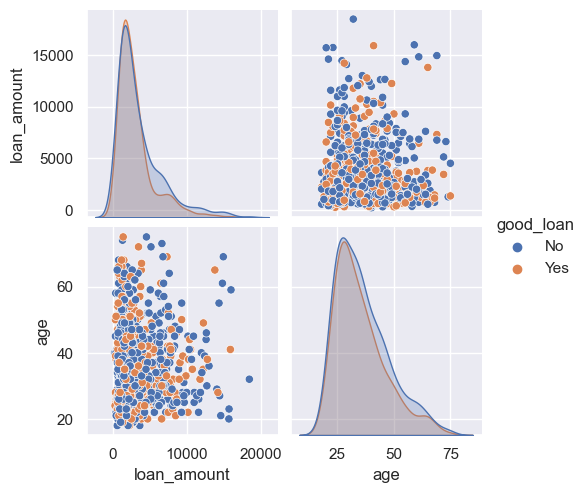

In [204]:
converted_to_pandas = my_dataset.toPandas()

g = sns.pairplot(converted_to_pandas, hue="good_loan")

# Investigating distribution of y i.e. good_loan
We need to plot a countplotto check the distribution of y, if it is immbalanced, then we have to take an action to balance it.

<AxesSubplot:xlabel='good_loan', ylabel='count'>

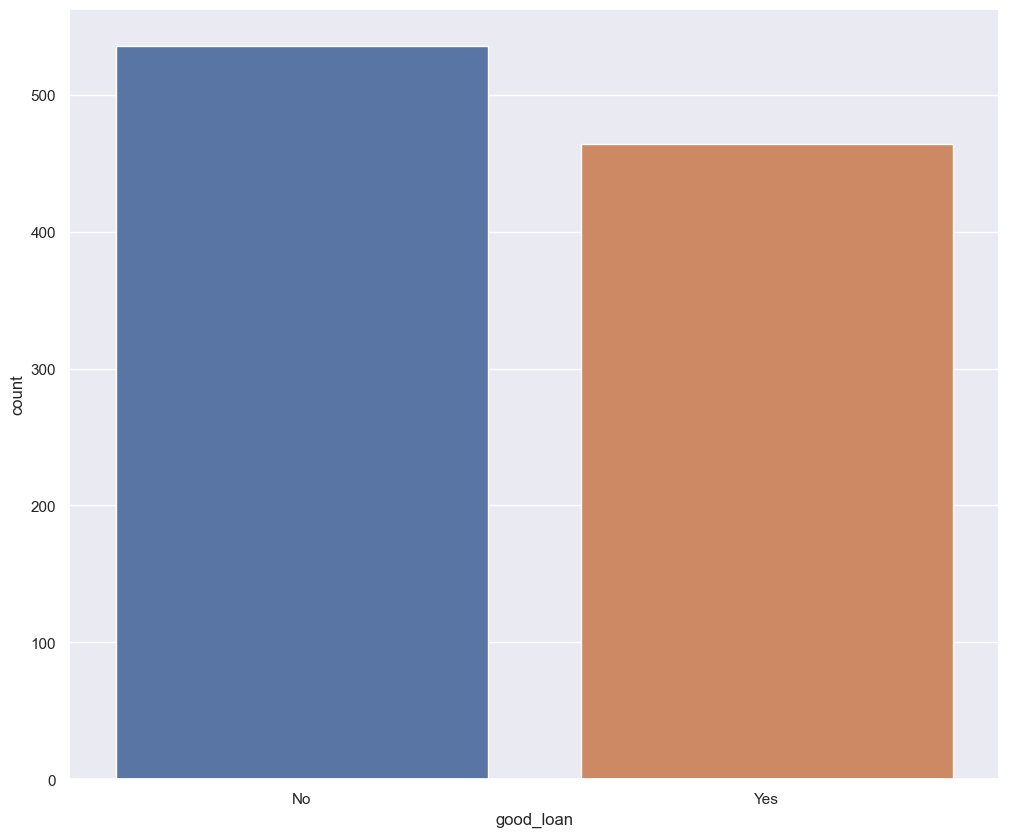

In [205]:
sns.countplot(x="good_loan", data=converted_to_pandas)

Analysing the impact of variables other than numeric ones on output (y)

In [206]:
converted_to_pandas.columns

Index(['type_of_account', 'account_history', 'reason_for_the_loan',
       'loan_amount', 'account_savings', 'employment_history',
       'individual_status', 'other_loans', 'security__collateral', 'age',
       'residence_status', 'job', 'completed_other_loan', 'good_loan'],
      dtype='object')

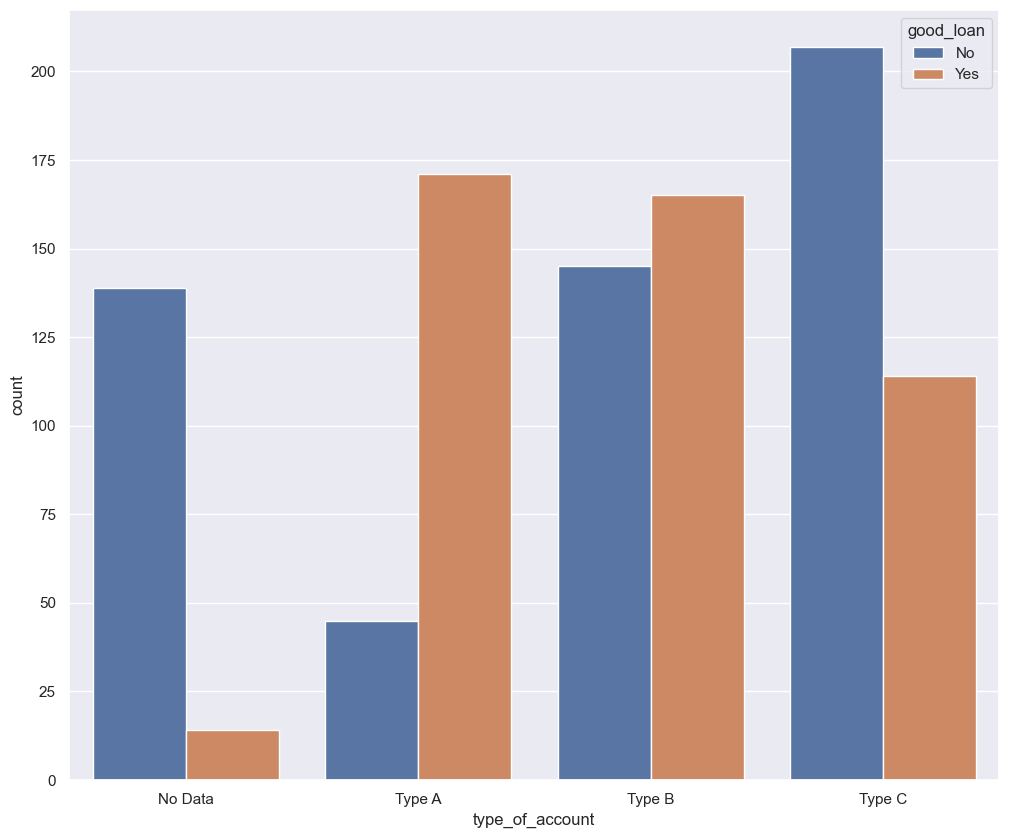

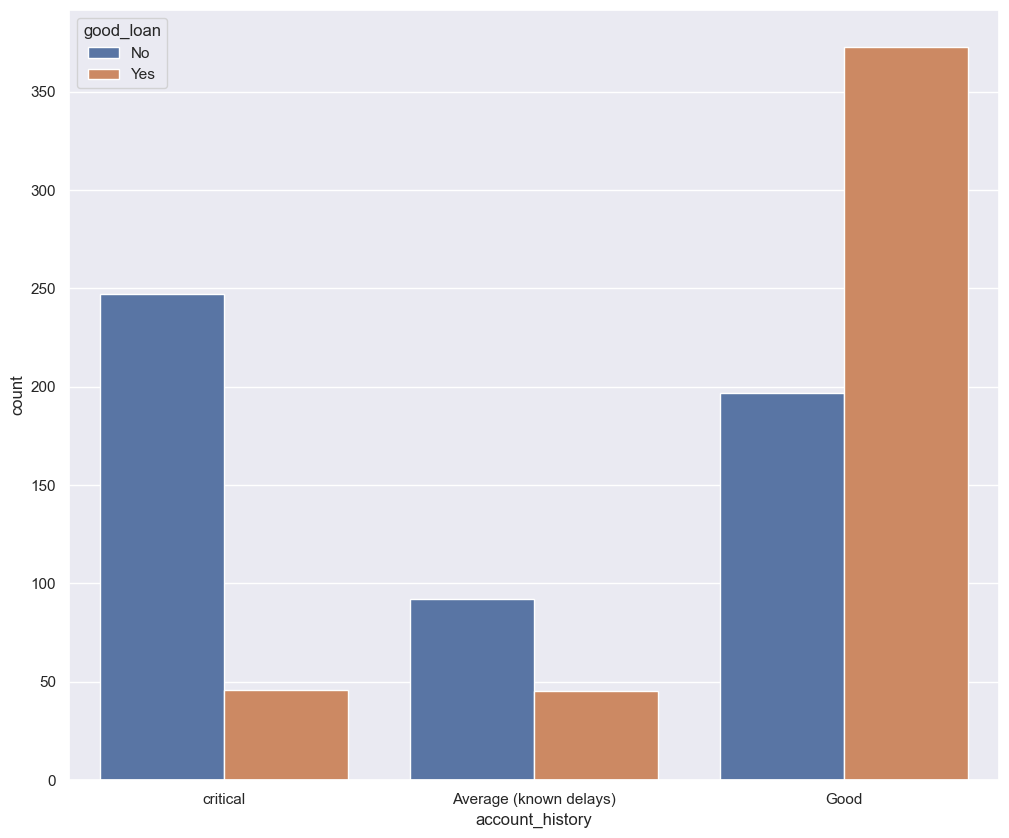

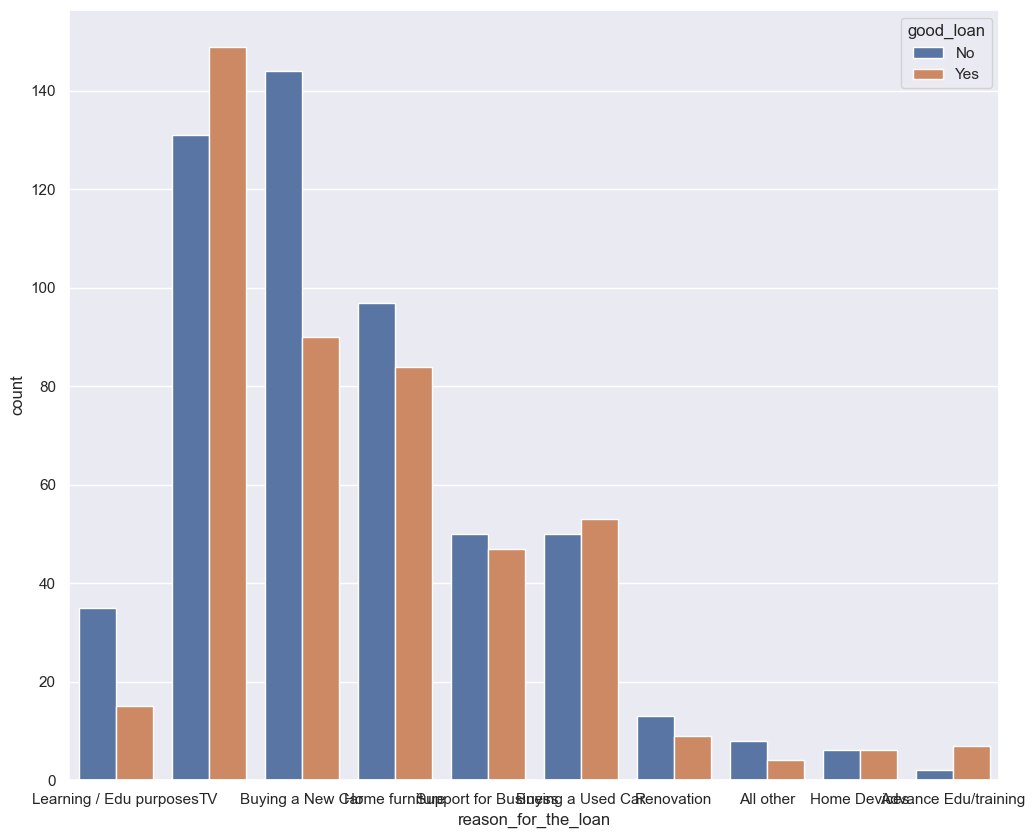

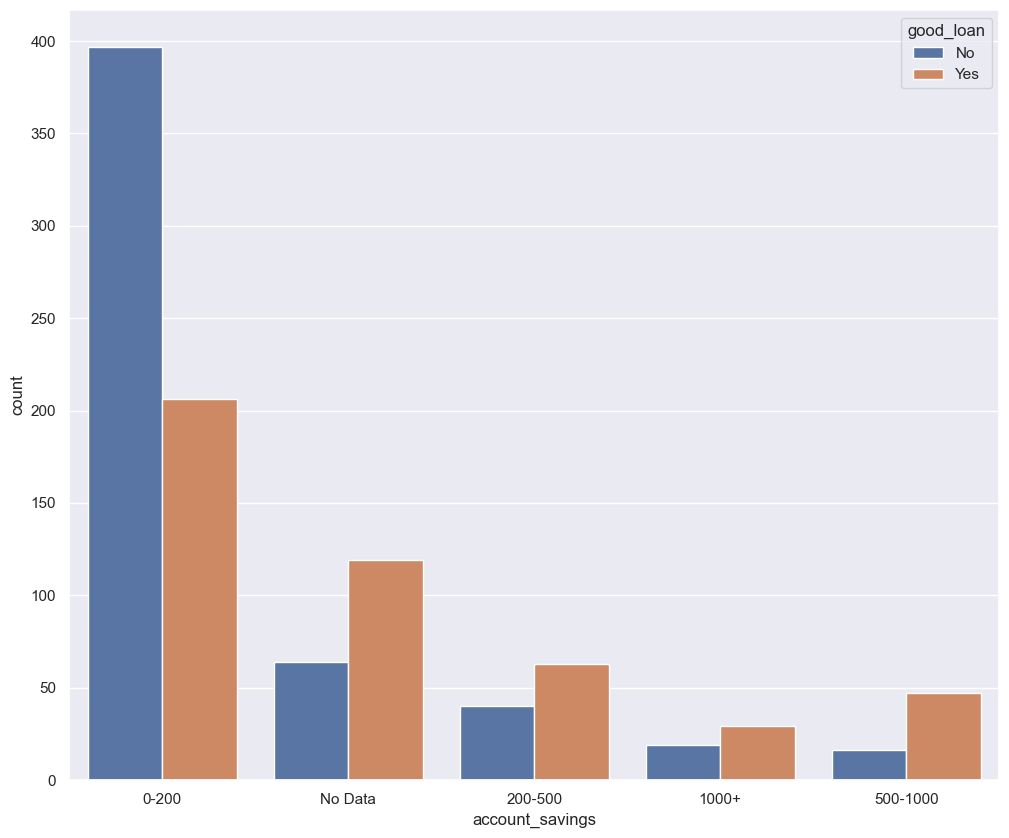

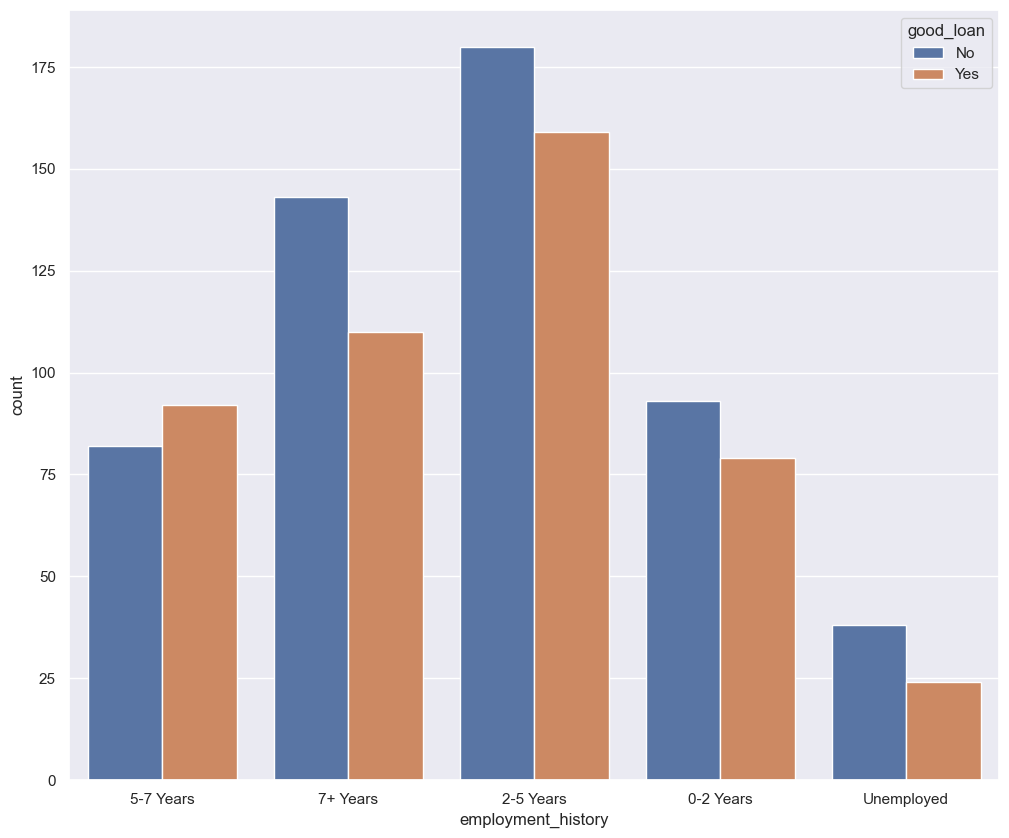

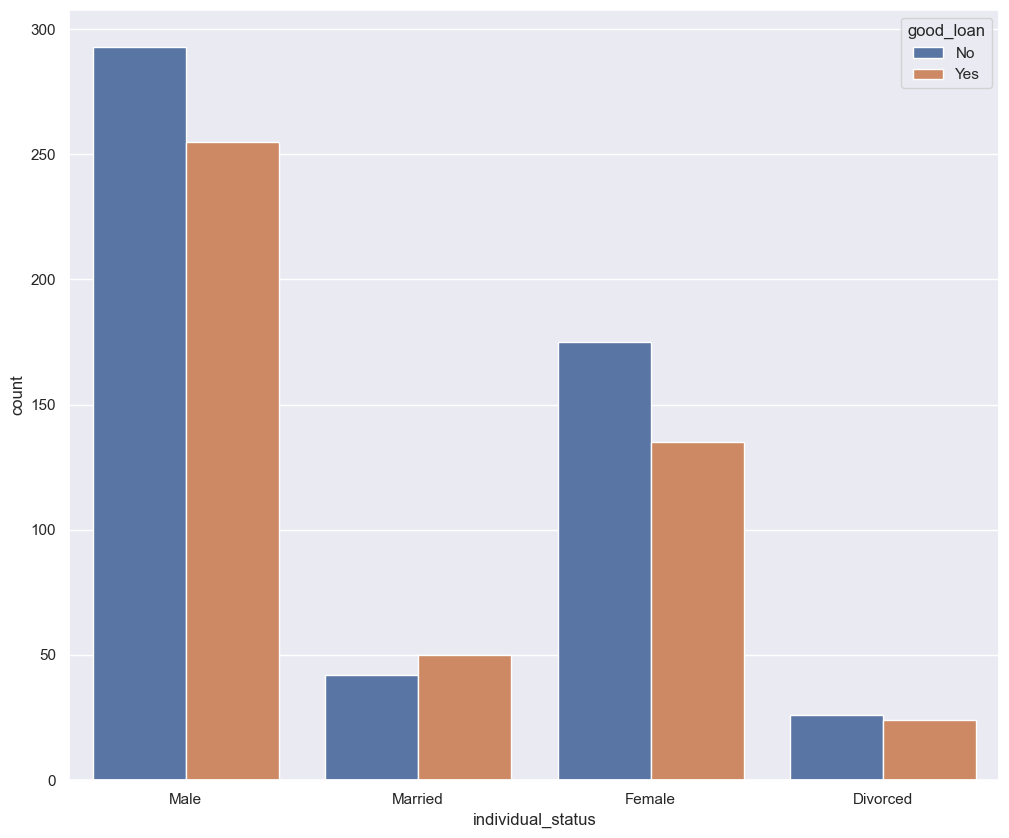

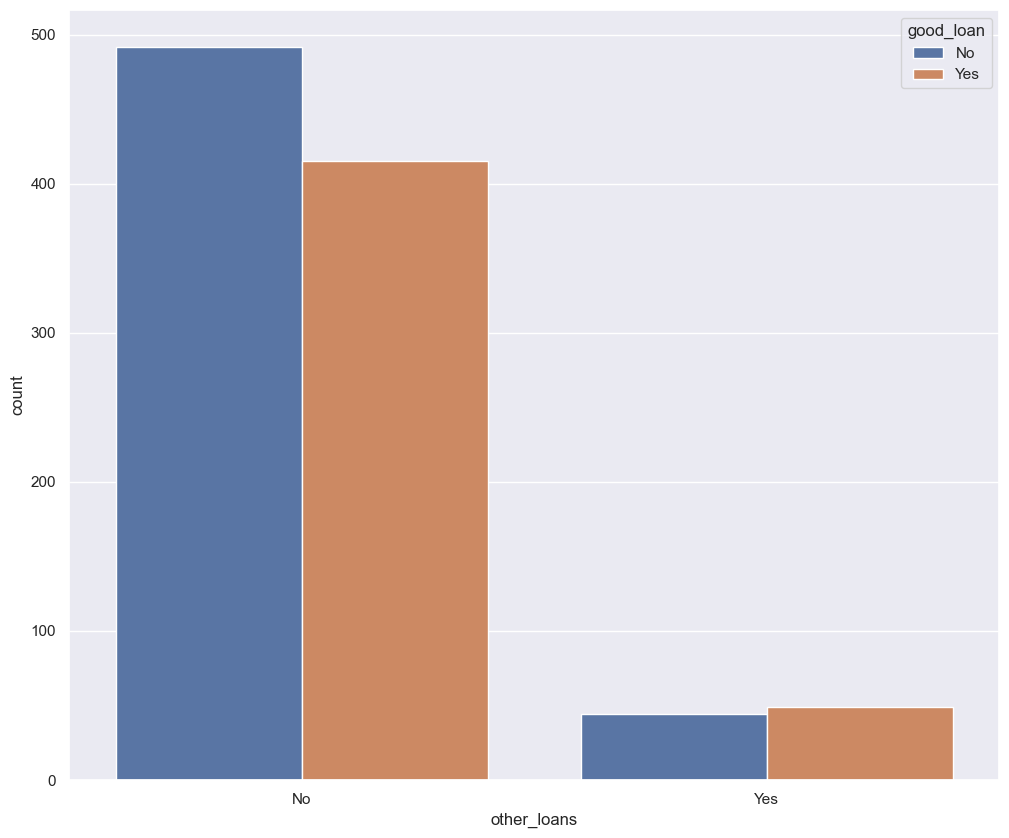

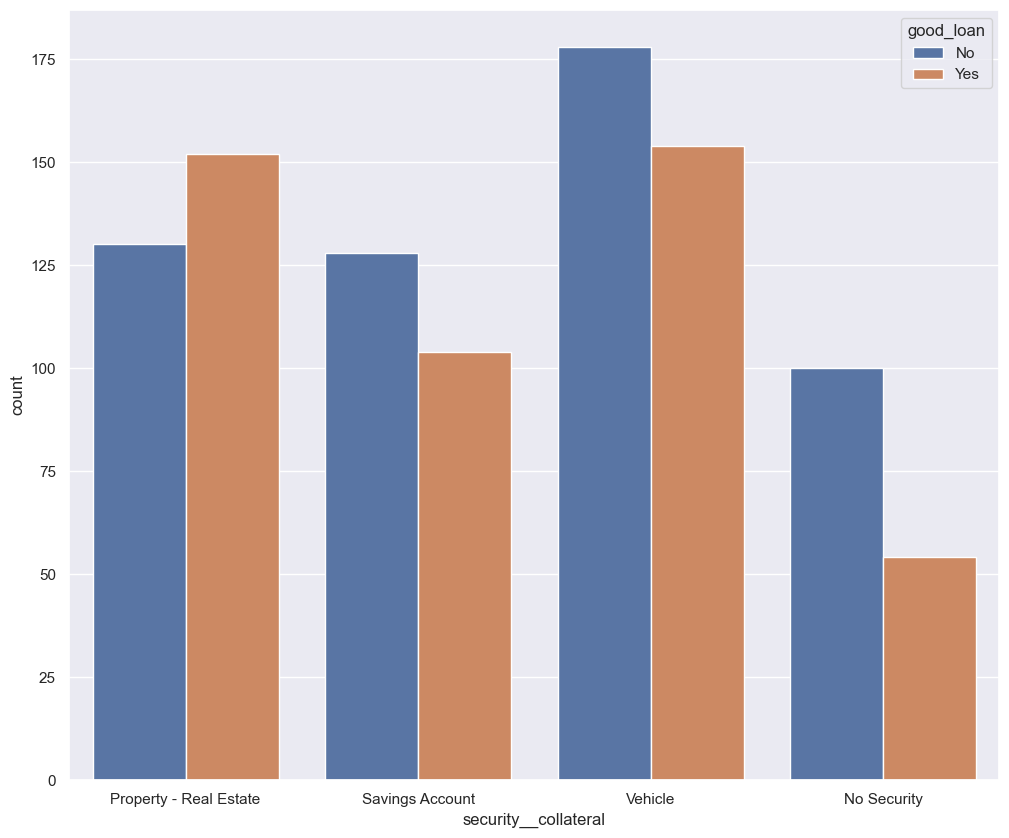

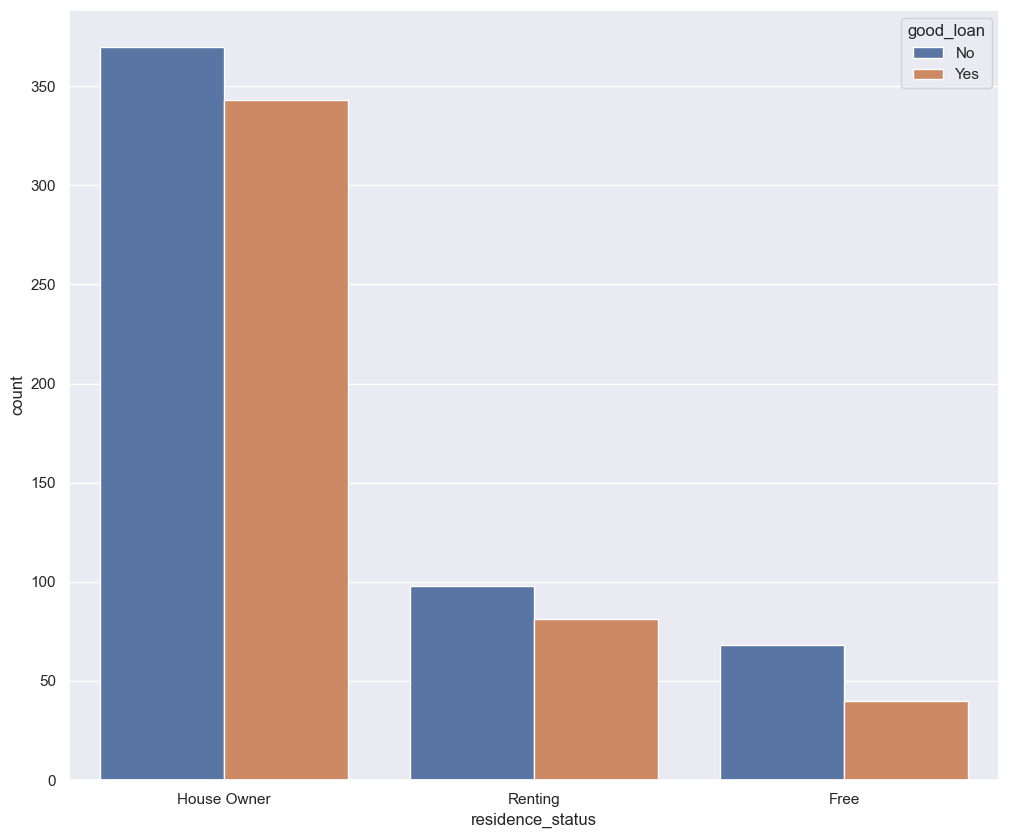

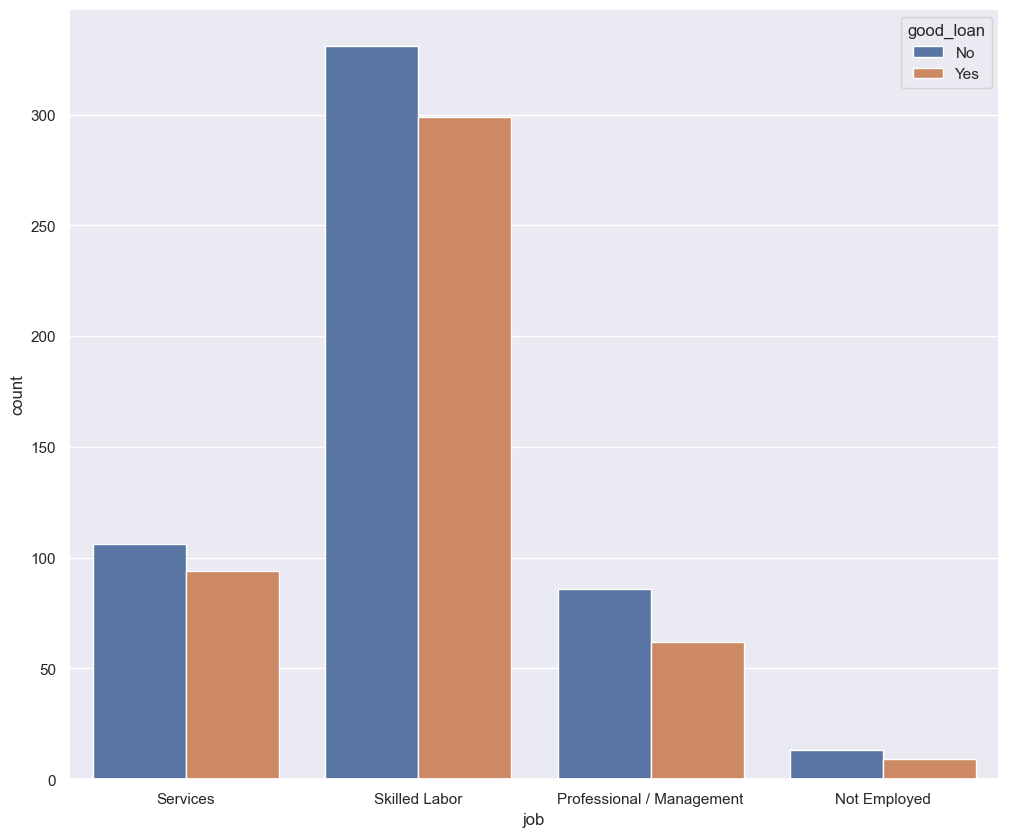

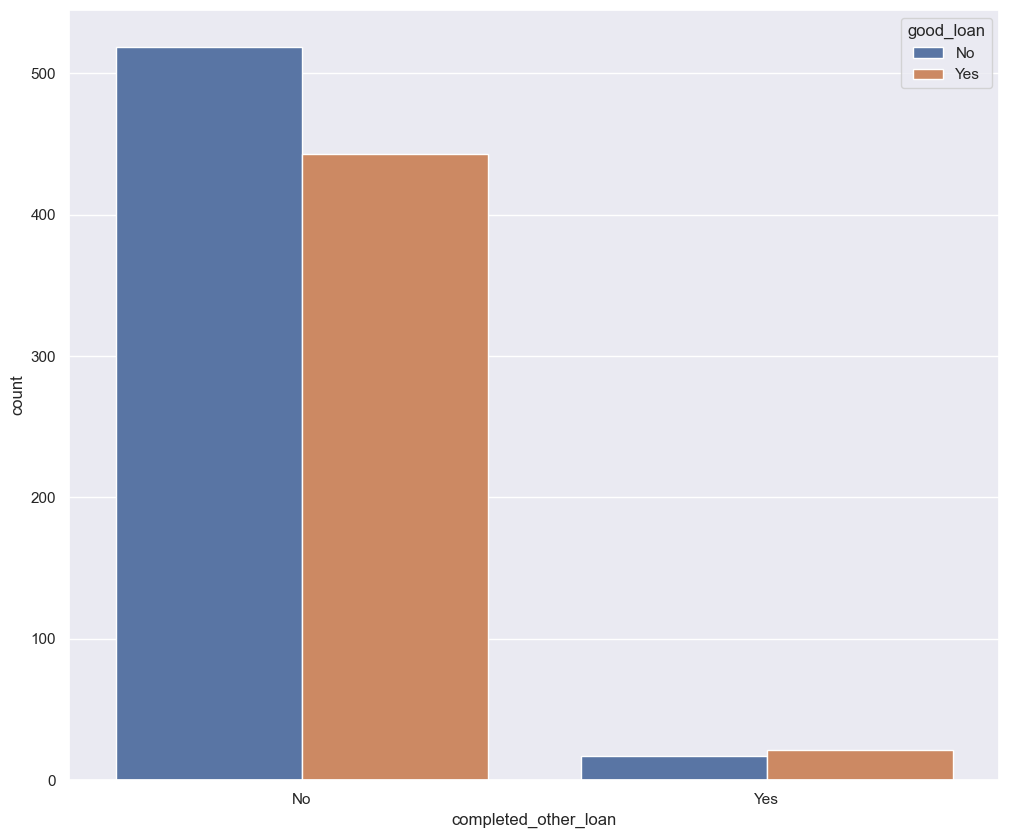

In [207]:
my_features = ['type_of_account', 'account_history', 'reason_for_the_loan', 'account_savings', 'employment_history',
               'individual_status', 'other_loans', 'security__collateral',
               'residence_status', 'job', 'completed_other_loan']

for f in my_features:
    sns.countplot(x=f, data=converted_to_pandas, hue='good_loan')
    plt.show()

Converting Strings to numbers so as to make the dta compatible with the algorithm.

In [208]:
my_dataset = my_dataset.withColumn("good_loan", when(col("good_loan") == "Yes", 1).otherwise(0))
my_dummies = pd.get_dummies(my_dataset.toPandas(), columns=my_features)
# my_dummies["good_loan"][my_dummies["good_loan"] == "Yes"] = 1
# my_dummies["good_loan"][my_dummies["good_loan"] == "No"] = 0
# my_dummies
# for pivot_col in ['account_history', 'reason_for_the_loan',
#             'account_savings', 'employment_history', 'individual_status',
#             'other_loans', 'security__collateral',
#             'residence_status', 'job', 'completed_other_loan']:
    
#     test = my_dataset. \

#         groupBy('loan_amount','age','good_loan'). \
#         pivot(pivot_col). \
#         agg(count('*')). \
#         fillna(0)

# my_dummies_pyspark = spark.createDataFrame(my_dummies)
cols=[]
for column in my_dummies.columns:
    new_column = str(column)
    new_column = re.sub('[\W_]+', ' ', new_column).strip().replace(" ","_").lower()
    cols.append(new_column)


my_dummies.columns = cols


# Feature Selection
We need to know which feature impacts our output the most.

In [209]:
X = my_dummies.drop("good_loan", axis=1).values
y = my_dummies["good_loan"]
y = y.astype(int)

# Decision Tree Classifier

Decision tree learning is a supervised learning approach used in statistics, data mining and machine learning. In this formalism, a classification or regression decision tree is used as a predictive model to draw conclusions about a set of observations.

Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. More generally, the concept of regression tree can be extended to any kind of object equipped with pairwise dissimilarities such as categorical sequences.[1]

Decision trees are among the most popular machine learning algorithms given their intelligibility and simplicity.[2]

In decision analysis, a decision tree can be used to visually and explicitly represent decisions and decision making. In data mining, a decision tree describes data (but the resulting classification tree can be an input for decision making).

# Tree Based Estimators

Tree based estimators like decision tree and random forest, help getting feature importances.

In [210]:
dt = DecisionTreeClassifier(random_state=15, criterion='entropy', max_depth=10)
dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

Get importnce of each feature on the variable y.

In [211]:
fi_col = []
fi = []
for i, column in enumerate(my_dummies.drop("good_loan", axis=1)):
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])


my_zip = zip(fi_col, fi)
my_feature_importances = pd.DataFrame(my_zip, columns=["feature Column", "Importance"]).sort_values("Importance", ascending=False).reset_index()


my_important_features = my_feature_importances.where(my_feature_importances["Importance"] > 0)["feature Column"].dropna()

# Splitting the RAW data

In [212]:
# numpy array of features

X = my_dummies[my_important_features].values
y = my_dummies["good_loan"]
y = y.astype(int).values

# Hold Out Validation

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=15)

print(f"Train Set : X = {X_train.shape}, Y = {y_train.shape}")
print(f"Test Set : X = {X_test.shape}, Y = {y_test.shape}")


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, train_size=0.9, random_state=15)

print(f"\nNew Train Set : X = {X_train.shape}, Y = {y_train.shape}")
print(f"New Test Set : X = {X_test.shape}, Y = {y_test.shape}")
print(f"CV Set : X = {X_valid.shape}, Y = {y_valid.shape}")




Train Set : X = (800, 40), Y = (800,)
Test Set : X = (200, 40), Y = (200,)

New Train Set : X = (720, 40), Y = (720,)
New Test Set : X = (200, 40), Y = (200,)
CV Set : X = (80, 40), Y = (80,)


# Investigate y's

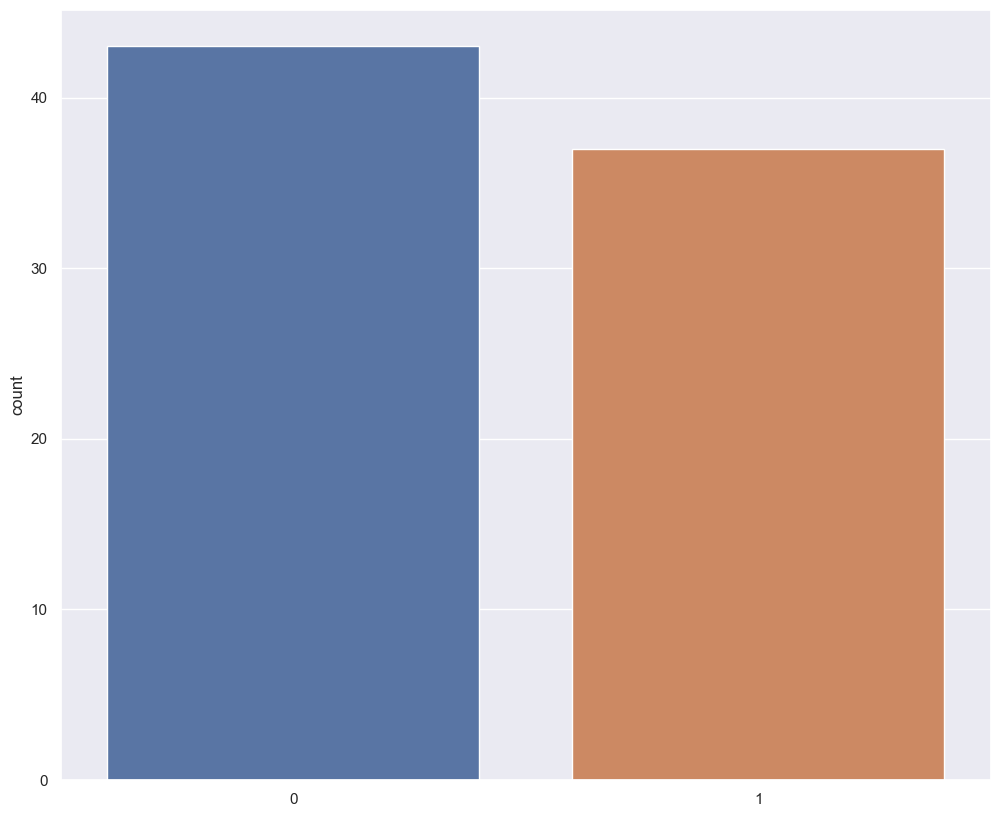

In [214]:
ax = sns.countplot(x=y_valid)

# Logistic Regression

Logistic regression, despite its name, is a classification algorithm rather than regression algorithm. Based on a given set of independent variables, it is used to estimate discrete value (0 or 1, yes/no, true/false). It is also called logit or MaxEnt Classifier.

Basically, it measures the relationship between the categorical dependent variable and one or more independent variables by estimating the probability of occurrence of an event using its logistics function.

sklearn.linear_model.LogisticRegression is the module used to implement logistic regression.





random_state − int, RandomState instance or None, optional, default = none, This parameter represents the seed of the pseudo random number generated which is used while shuffling the data.

solver − str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘saag’, ‘saga’}, optional, default = ‘liblinear’ This parameter represents which algorithm to use in the optimization problem. Followings are the properties of options under this parameter
- liblinear − It is a good choice for small datasets. It also handles L1 penalty. For multiclass problems, it is limited to one-versus-rest schemes.

- newton-cg − It handles only L2 penalty.

- lbfgs − For multiclass problems, it handles multinomial loss. It also handles only L2 penalty.

- saga − It is a good choice for large datasets. For multiclass problems, it also handles multinomial loss. Along with L1 penalty, it also supports ‘elasticnet’ penalty.

- sag − It is also used for large datasets. For multiclass problems, it also handles multinomial loss.





In [215]:
log_reg = LogisticRegression(random_state=10, solver = 'lbfgs')
log_reg.fit(X_train, y_train)

# Methods we can use in Logistic

# predict - Predict class labels for samples in X
log_reg.predict(X_train)
y_pred = log_reg.predict(X_train)

print(y_pred)

# predict_proba - Probability estimates
pred_proba = log_reg.predict_proba(X_train)
print(pred_proba)

 	
# coef_ − array, shape(n_features,) or (n_classes, n_features)
# It is used to estimate the coefficients of the features in the decision function. When the given problem is binary, it is of the shape (1, n_features).
print(log_reg.coef_)


[0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1
 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0
 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1
 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0
 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0
 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0
 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0
 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1
 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1
 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0
 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1
 1 0 0 0 1 1 1 1 1 0 1 0 

# Model Evaluation

In [216]:
# score- Returns the mean accuracy on the given test data and labels - below

# Return the mean accuracy on the given test data and labels.

# In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

# Parameters
# X : array-like of shape (n_samples, n_features)
#     Test samples.

# y : array-like of shape (n_samples,) or (n_samples, n_outputs)
#     True labels for X.

# sample_weight : array-like of shape (n_samples,), default=None
#     Sample weights.

# Returns
# score : float
#     Mean accuracy of self.predict(X) wrt. y.

# Accuracy on Train
# Mean accuracy of self.predict(X) wrt. y.
print("The Training Accuracy is: ", log_reg.score(X_train, y_train))

# Accuracy on Test
print("The Testing Accuracy is: ", log_reg.score(X_test, y_test))


# Classification Report
print(classification_report(y_train, y_pred))

	
# classes_ − array, shape(n_classes)

# It will provide a list of class labels known to the classifier.
print(log_reg.classes_)

The Training Accuracy is:  0.7791666666666667
The Testing Accuracy is:  0.75
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       387
           1       0.77      0.75      0.76       333

    accuracy                           0.78       720
   macro avg       0.78      0.78      0.78       720
weighted avg       0.78      0.78      0.78       720

[0 1]


In [217]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

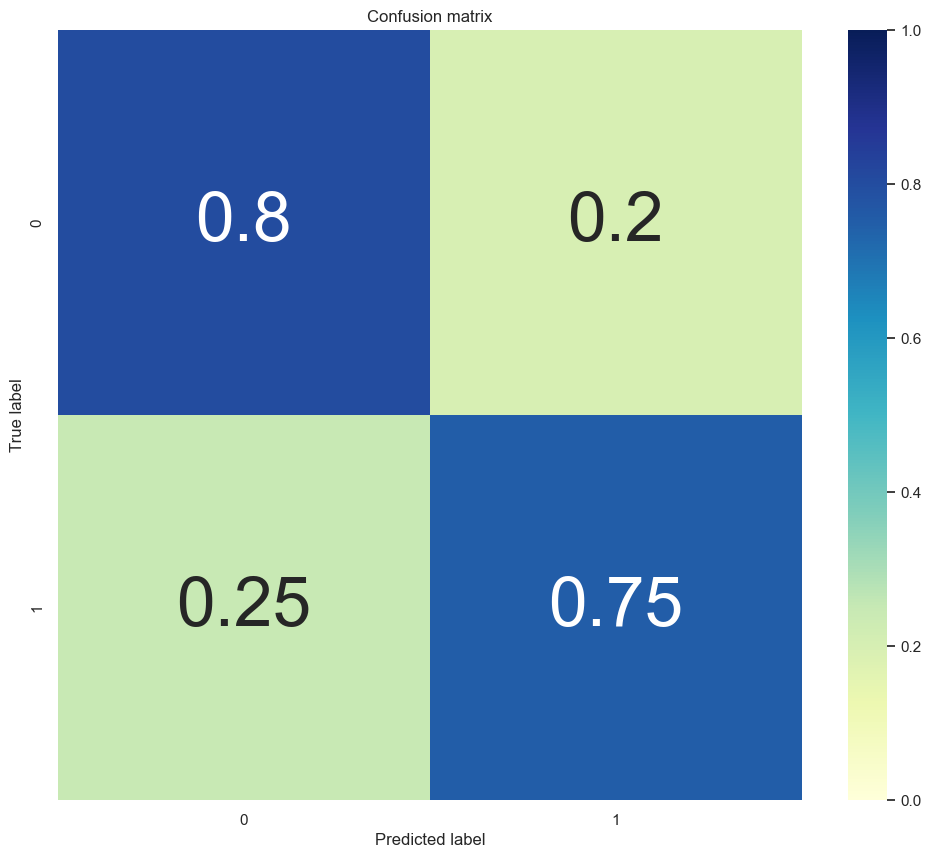

In [218]:
# Visualizing cm

cm = confusion_matrix(y_train, y_pred)

# [[311  76]
#  [ 83 250]]
# [[387]
#  [333]]
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [219]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)
# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)
# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)
# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)
##Total averages :
print("")
print("The average TPR is:", TPR.sum()/2)
print("The average Precision is:", PPV.sum()/2)
print("The average False positive rate is:", FPR.sum()/2)
print("The average False Negative Rate is:", FNR.sum()/2)

The True Positive Rate is: [0.803618 0.750751]
The Precision is: [0.789340 0.766871]
The False positive rate is: [0.249249 0.196382]
The False Negative Rate is:  [0.196382 0.249249]

The average TPR is: 0.7771841609050911
The average Precision is: 0.7781056335835073
The average False positive rate is: 0.22281583909490887
The average False Negative Rate is: 0.22281583909490887


#### Logarithmic loss - or Log Loss - or cross-entropy loss

- Log Loss is an error metric
- This is the loss function used in (multinomial) logistic regression and extensions of it such as neural networks, defined as the negative log-likelihood of the true labels given a probabilistic classifier’s predictions. 

- Why it's important? For example, imagine having 2 models / classifiers that both predict one observation correctly (Good Loan). However, 1 classifier has a predicted probability of 0.54 and the other 0.95. Which one will you choose? Classification Accuracy will not help here as it will get both on 100%

- Doc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html

In [220]:
# Running Log loss on training
print("The Log Loss on Training is: ", log_loss(y_train, pred_proba))

# Running Log loss on testing
pred_proba_t = log_reg.predict_proba(X_test)
print("The Log Loss on Testing Dataset is: ", log_loss(y_test, pred_proba_t))


The Log Loss on Training is:  0.4561218472546489
The Log Loss on Testing Dataset is:  0.49358753587385484


## 10. Hyper Parameter Tuning

- We will loop over parameter C (Inverse of regularization strength).
- Inverse of regularization strength helps to avoid overfitting - it penalizes large values of your parameters
- It also helps to find Global Minimum by moving to better "solutions" from local minimum to global minimum
- The values of C to search should be n-equally-spaced values in log space ranging from 1e-5 to 1e5

In [221]:
np.geomspace(1e-5, 1e5, num=20)

array([0.000010, 0.000034, 0.000113, 0.000379, 0.001274, 0.004281,
       0.014384, 0.048329, 0.162378, 0.545559, 1.832981, 6.158482,
       20.691381, 69.519280, 233.572147, 784.759970, 2636.650899,
       8858.667904, 29763.514416, 100000.000000])

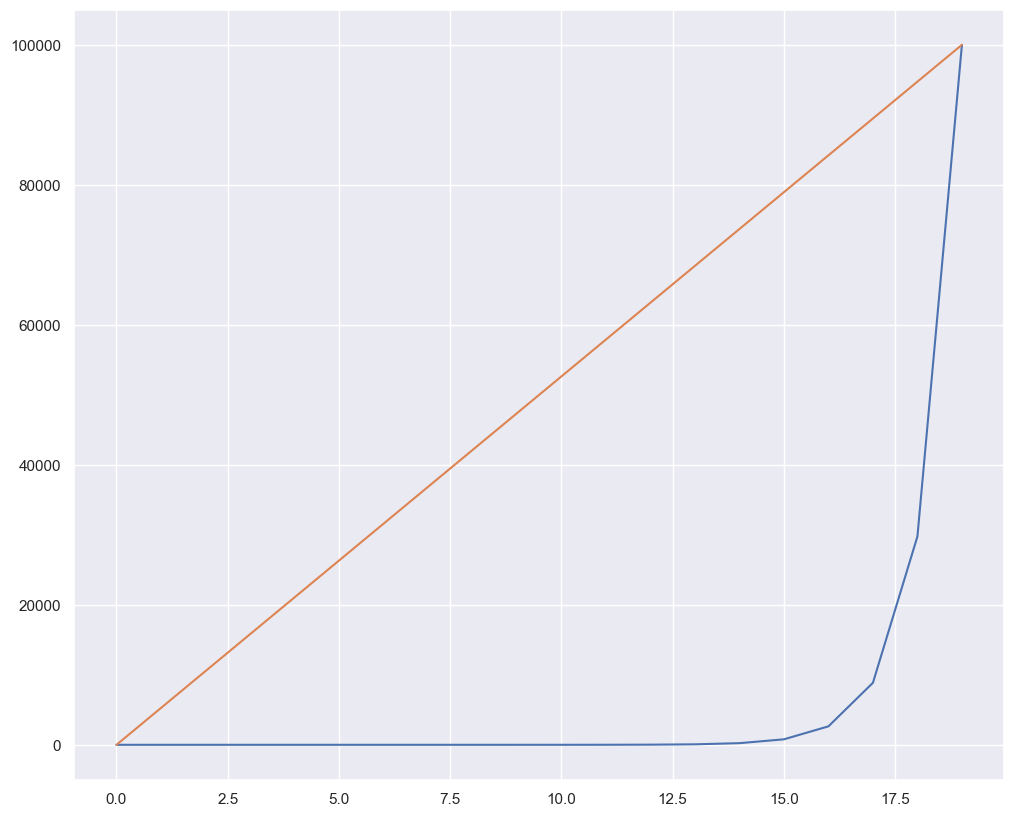

In [222]:
# Creating a range for C values
np.geomspace(1e-5, 1e5, num=20)

# ploting it
plt.plot(np.geomspace(1e-5, 1e5, num=20)) #  uniformly distributed in log space
plt.plot(np.linspace(1e-5, 1e5, num=20)) # uniformly distributed in linear space, instead of log space
# plt.plot(np.logspace(np.log10(1e-5) , np.log10(1e5) , num=20)) # same as geomspace


# Looping over the parameters

In [223]:
C_List = np.geomspace(1e-5, 1e5, num=20)
C_List
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'lbfgs', C=c)
    log_reg2.fit(X_train, y_train)
    score = log_reg2.score(X_test, y_test)
    CA.append(score)
    pred_proba_t = log_reg2.predict_proba(X_test)
    log_loss2 = log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Showing the ablove results.

In [224]:
# putting the outcomes in a Table

# reshaping
CA2 = np.array(CA).reshape(20,)
Logarithmic_Loss2 = np.array(Logarithmic_Loss).reshape(20,)

# zip
outcomes = zip(C_List, CA2, Logarithmic_Loss2)

#df
df_outcomes = pd.DataFrame(outcomes, columns = ["C_List", 'Classification Accuracy','Logarithmic_Loss2'])

# Ordering the data (sort_values)
df_outcomes.sort_values("Logarithmic_Loss2", ascending = True).reset_index()


df_outcomes

,C_List,Classification Accuracy,Logarithmic_Loss2
0,0.000010,0.535,0.696240
1,0.000034,0.540,0.694264
2,0.000113,0.540,0.692753
3,0.000379,0.545,0.687508
4,0.001274,0.640,0.671477
5,0.004281,0.670,0.632992
6,0.014384,0.725,0.573342
7,0.048329,0.705,0.522322
8,0.162378,0.745,0.498716
9,0.545559,0.745,0.493521


K-Folds cross-validator
K-folds is a cross validation generator
Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

LogisticRegressionCV implements logistic regression with built in cv to find optimal C value

- It goes through corss validation internally

In [225]:
kf = KFold(n_splits=3, random_state=0, shuffle=True)
log_regcv = LogisticRegressionCV(cv=kf, random_state=15, Cs=C_List)
log_regcv.fit(X_train, y_train)

accuracy_score_cv = log_regcv.score(X_test, y_test)
pred_proba_cv = log_regcv.predict_proba(X_test)
print("accuracy_score : ", accuracy_score_cv)
print("pred_proba : ", pred_proba_cv)
print("log_loss : ", log_loss(y_test, pred_proba_cv))
print("Optimal C : ",log_regcv.C_)

accuracy_score :  0.755
pred_proba :  [[0.203138 0.796862]
 [0.790170 0.209830]
 [0.531897 0.468103]
 [0.389759 0.610241]
 [0.949595 0.050405]
 [0.749628 0.250372]
 [0.456941 0.543059]
 [0.247200 0.752800]
 [0.313154 0.686846]
 [0.760925 0.239075]
 [0.710636 0.289364]
 [0.875790 0.124210]
 [0.862746 0.137254]
 [0.831923 0.168077]
 [0.250531 0.749469]
 [0.248738 0.751262]
 [0.908327 0.091673]
 [0.314678 0.685322]
 [0.965594 0.034406]
 [0.823015 0.176985]
 [0.853289 0.146711]
 [0.472545 0.527455]
 [0.233816 0.766184]
 [0.920121 0.079879]
 [0.110210 0.889790]
 [0.497561 0.502439]
 [0.703056 0.296944]
 [0.929186 0.070814]
 [0.237740 0.762260]
 [0.880539 0.119461]
 [0.160154 0.839846]
 [0.731245 0.268755]
 [0.493506 0.506494]
 [0.807481 0.192519]
 [0.926831 0.073169]
 [0.586736 0.413264]
 [0.892948 0.107052]
 [0.243775 0.756225]
 [0.356291 0.643709]
 [0.192734 0.807266]
 [0.465496 0.534504]
 [0.939850 0.060150]
 [0.825636 0.174364]
 [0.058196 0.941804]
 [0.822000 0.178000]
 [0.283162 0.7168

K-fold cross validation:
Advantage: K-fold cross validation uses all the training data to train the model, by applying k different splits; repeated train-test splits converge to the true accuracy given that the training data is representable for the underlying distribution; however in practise this is often overoptimistic. Disadvantage: The disadvantage of this method is that the training algorithm has to be rerun from the beginning k times, which means it takes k times as much computation to get an evaluation. Additionally, if you want to test the performance on a completely new dataset that the algorithm has never seen, you cannot do this with k-fold cross validation.

Hold-out:
Advantage: The advantage of Hold-out is that you can test how your model performs on completely unseen data that you haven't used when training the model. Additionally, Hold-out is usually much faster and less computationally expensive. Disadvantage: The evaluation may depend heavily on which data points end up in the training set and which end up in the test set, and thus the evaluation may be significantly different depending on how the division is made.

The CA of C parameter 1e-05 is 0.535:
The Logg Loss of C parameter 1e-05 is 0.696240240769562:



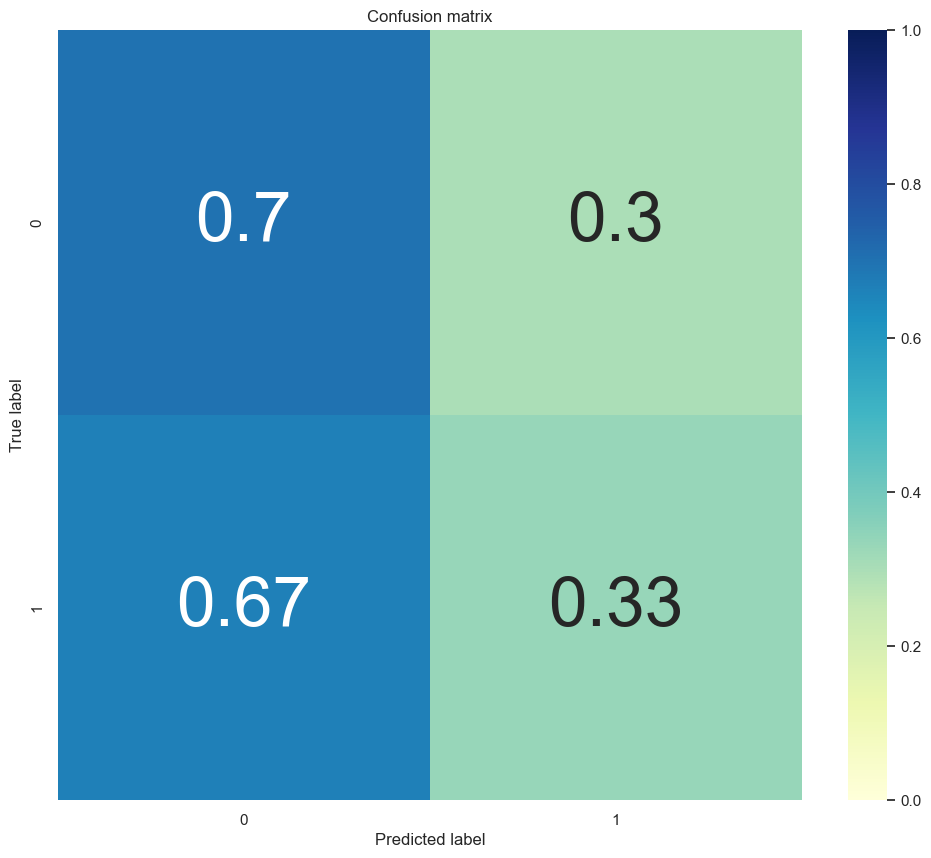

The CA of C parameter 3.359818286283781e-05 is 0.54:
The Logg Loss of C parameter 3.359818286283781e-05 is 0.6942639549968328:



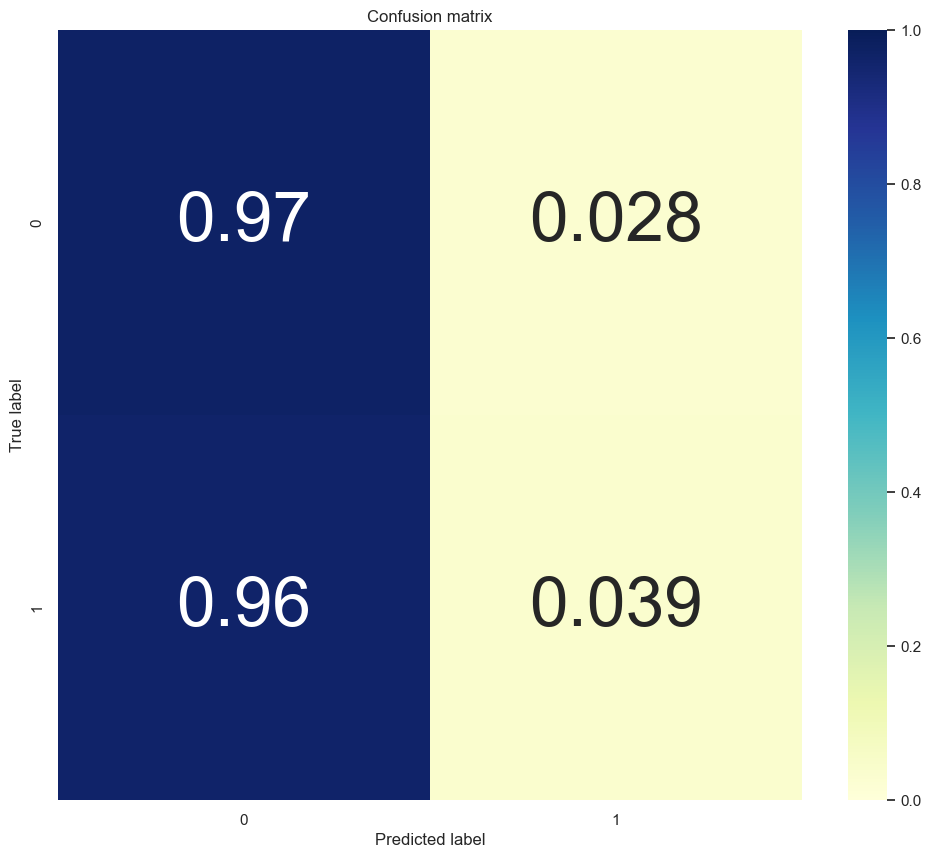

The CA of C parameter 0.00011288378916846884 is 0.54:
The Logg Loss of C parameter 0.00011288378916846884 is 0.692752630814025:



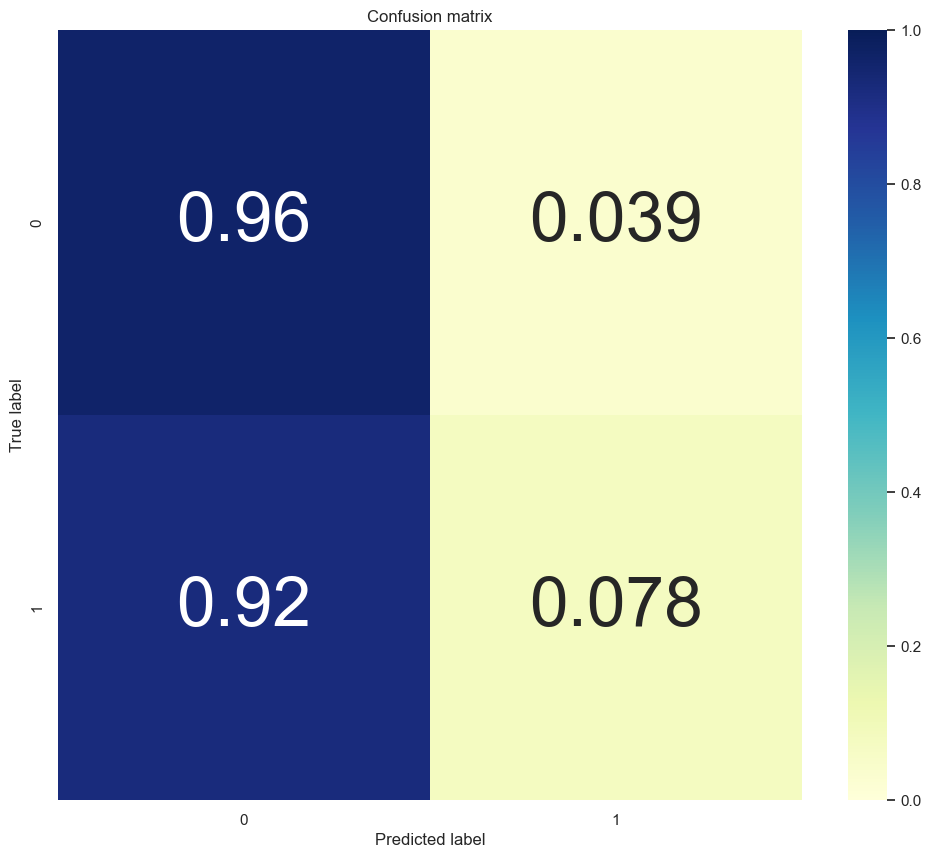

The CA of C parameter 0.000379269019073225 is 0.545:
The Logg Loss of C parameter 0.000379269019073225 is 0.687507944380954:



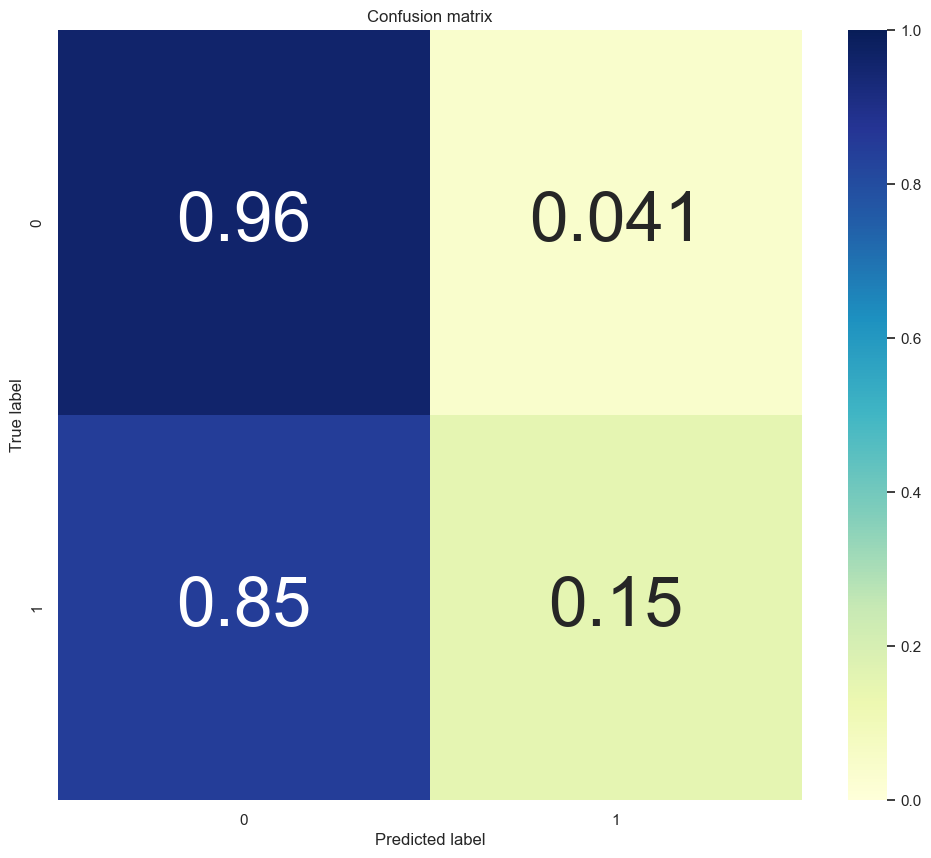

The CA of C parameter 0.0012742749857031334 is 0.64:
The Logg Loss of C parameter 0.0012742749857031334 is 0.6714766139180065:



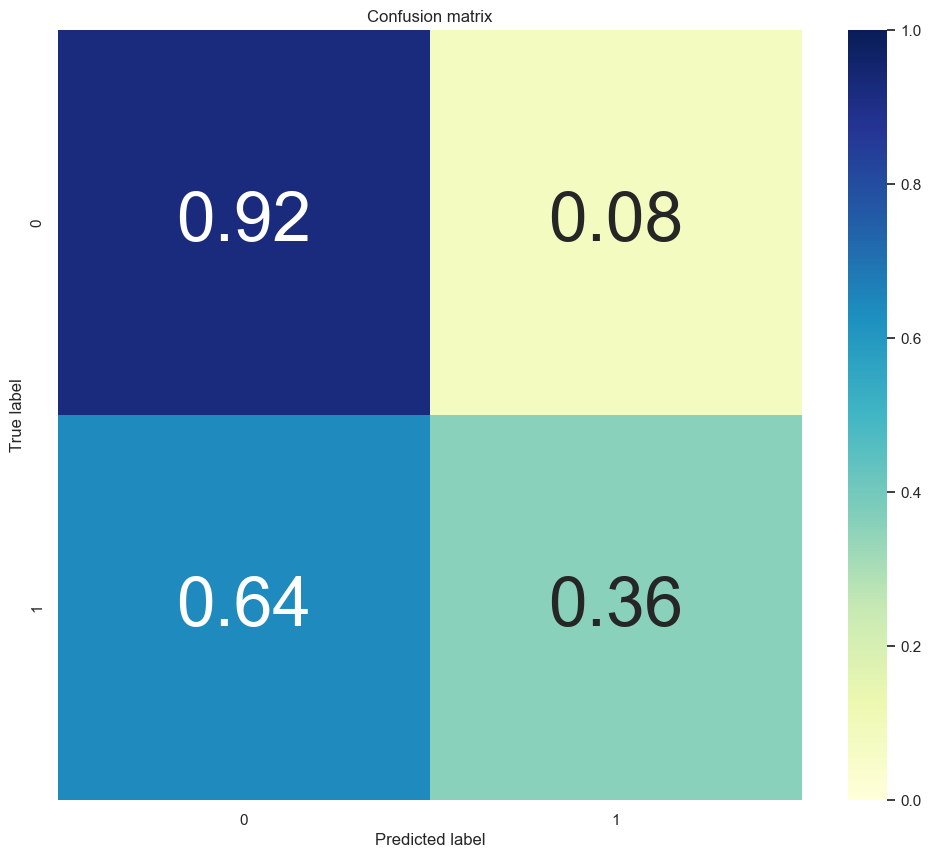

The CA of C parameter 0.004281332398719391 is 0.67:
The Logg Loss of C parameter 0.004281332398719391 is 0.6329923109584822:



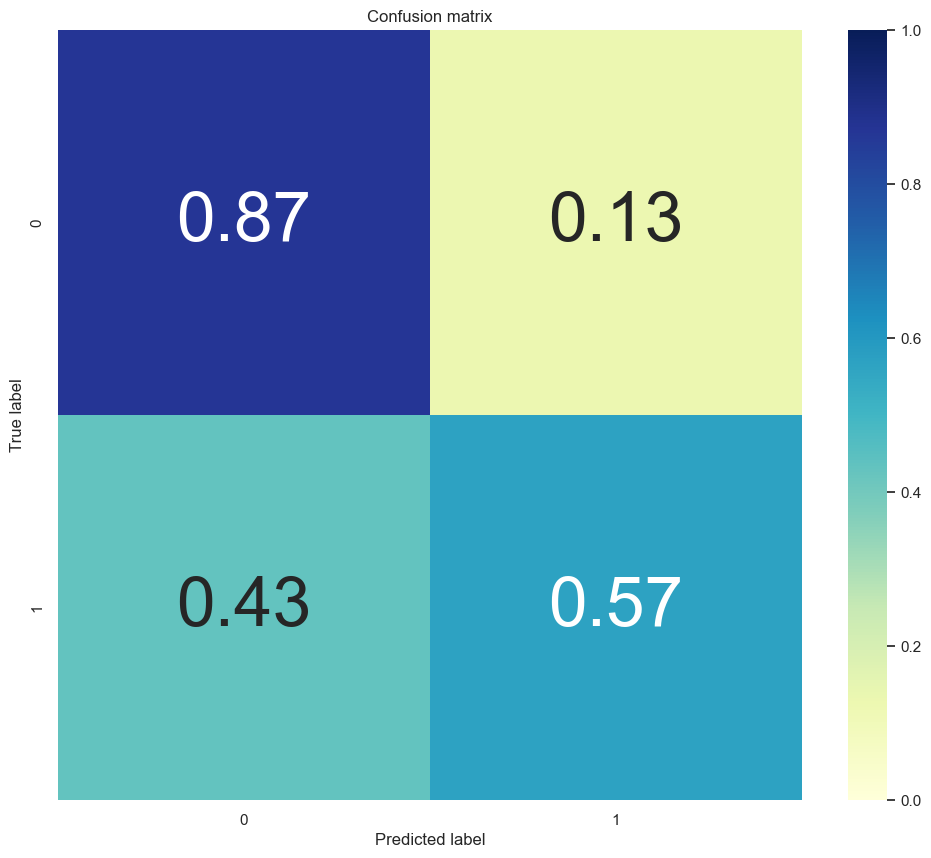

The CA of C parameter 0.01438449888287663 is 0.725:
The Logg Loss of C parameter 0.01438449888287663 is 0.573341996355269:



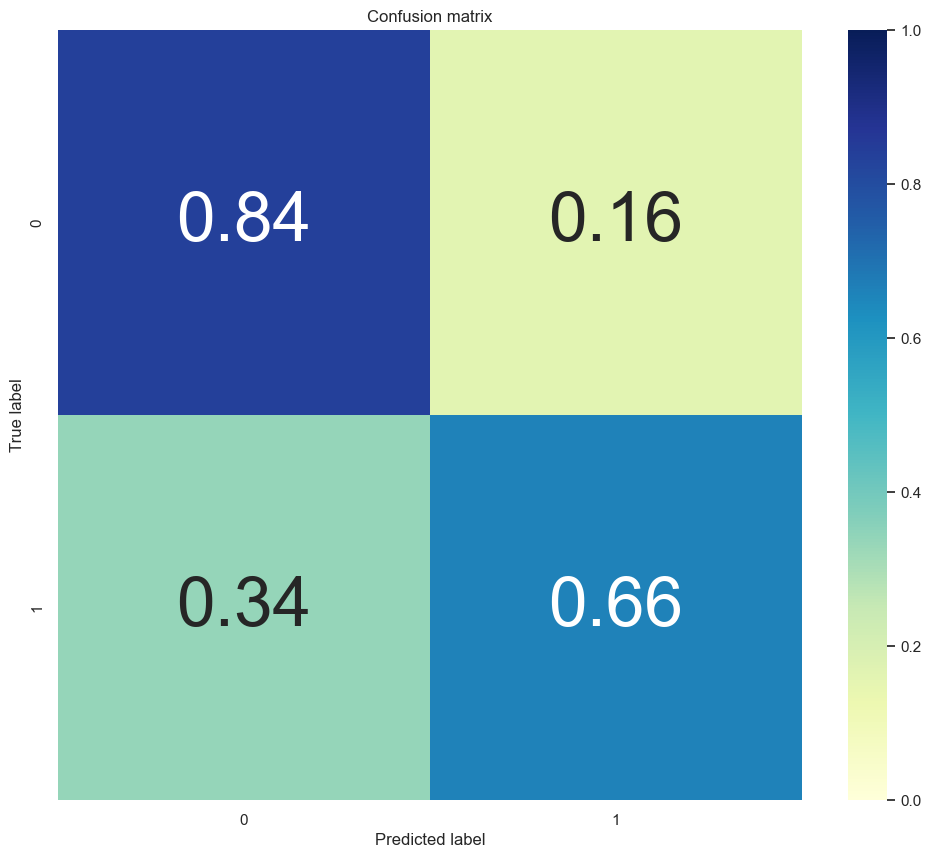

The CA of C parameter 0.04832930238571752 is 0.705:
The Logg Loss of C parameter 0.04832930238571752 is 0.5223217366495589:



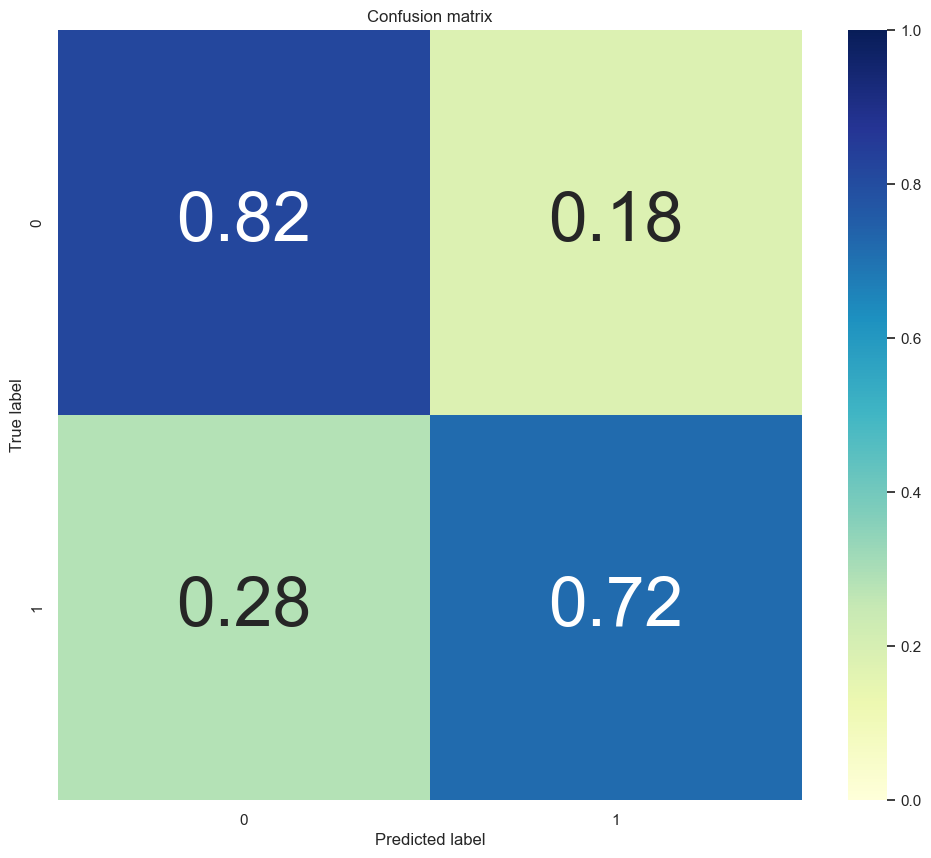

The CA of C parameter 0.1623776739188721 is 0.745:
The Logg Loss of C parameter 0.1623776739188721 is 0.49871561227183053:



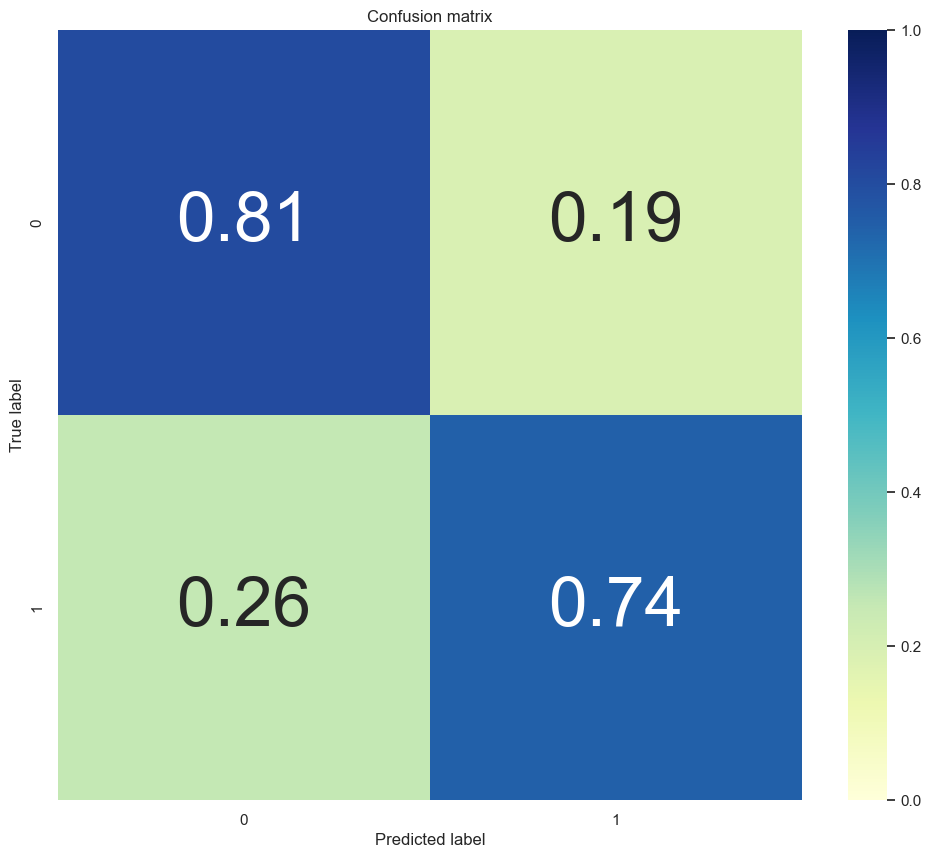

The CA of C parameter 0.5455594781168515 is 0.745:
The Logg Loss of C parameter 0.5455594781168515 is 0.49352070105914814:



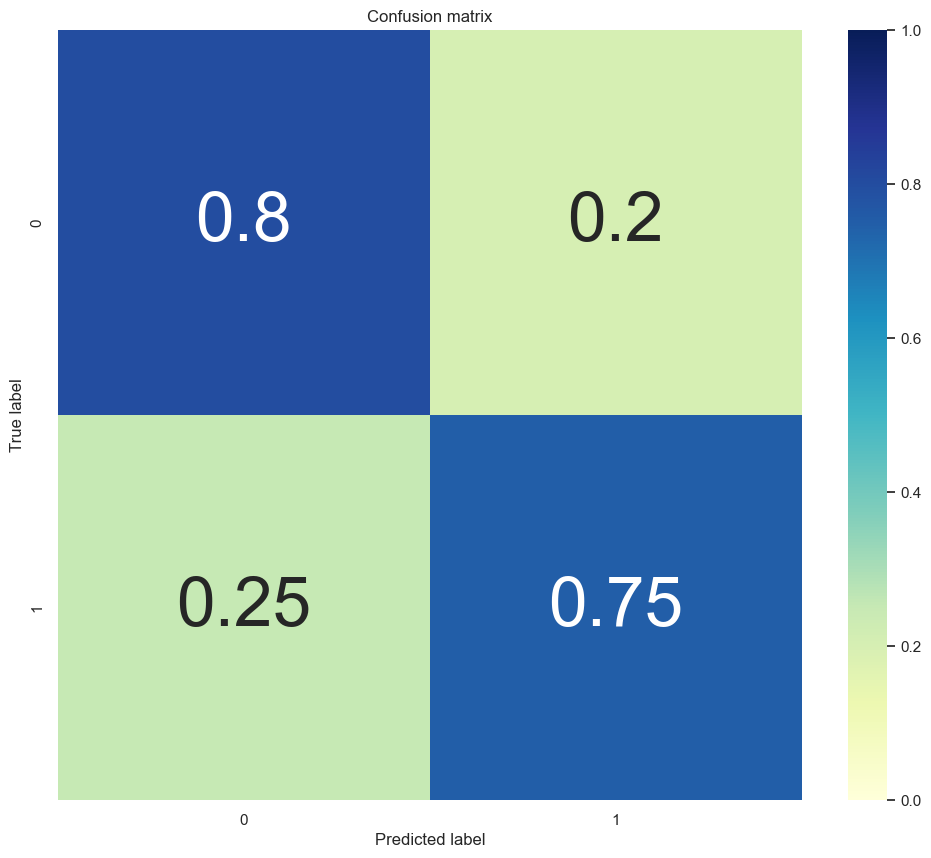

The CA of C parameter 1.8329807108324339 is 0.75:
The Logg Loss of C parameter 1.8329807108324339 is 0.4935509198034096:



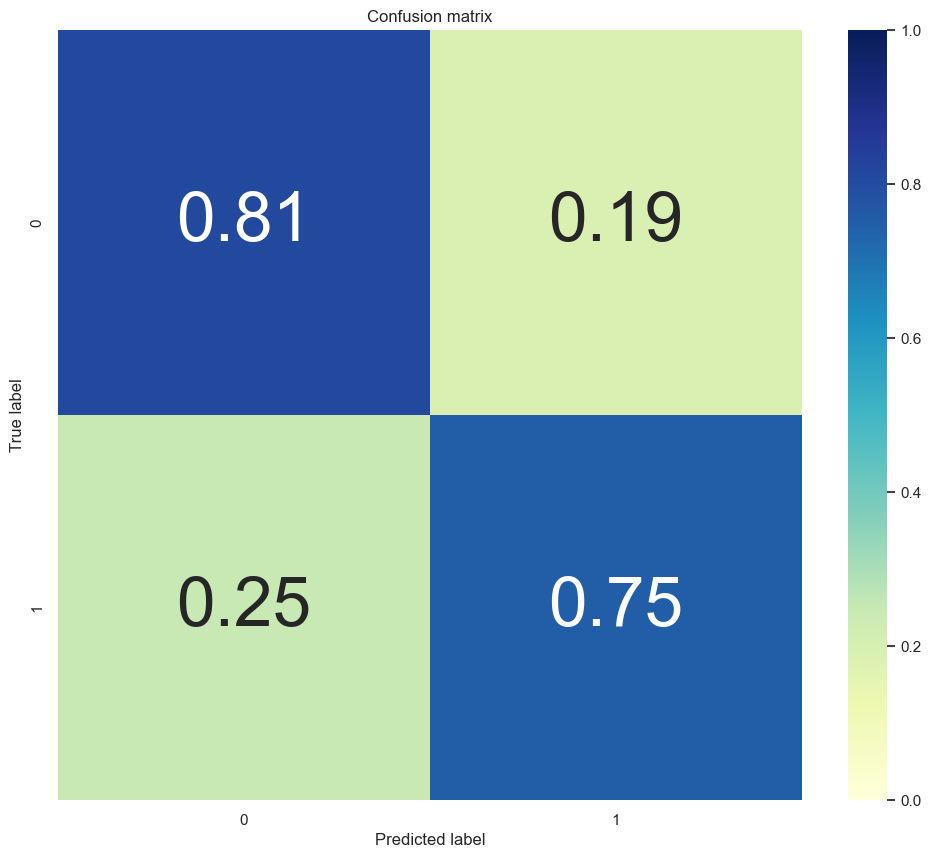

The CA of C parameter 6.1584821106602545 is 0.76:
The Logg Loss of C parameter 6.1584821106602545 is 0.4949811949130428:



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


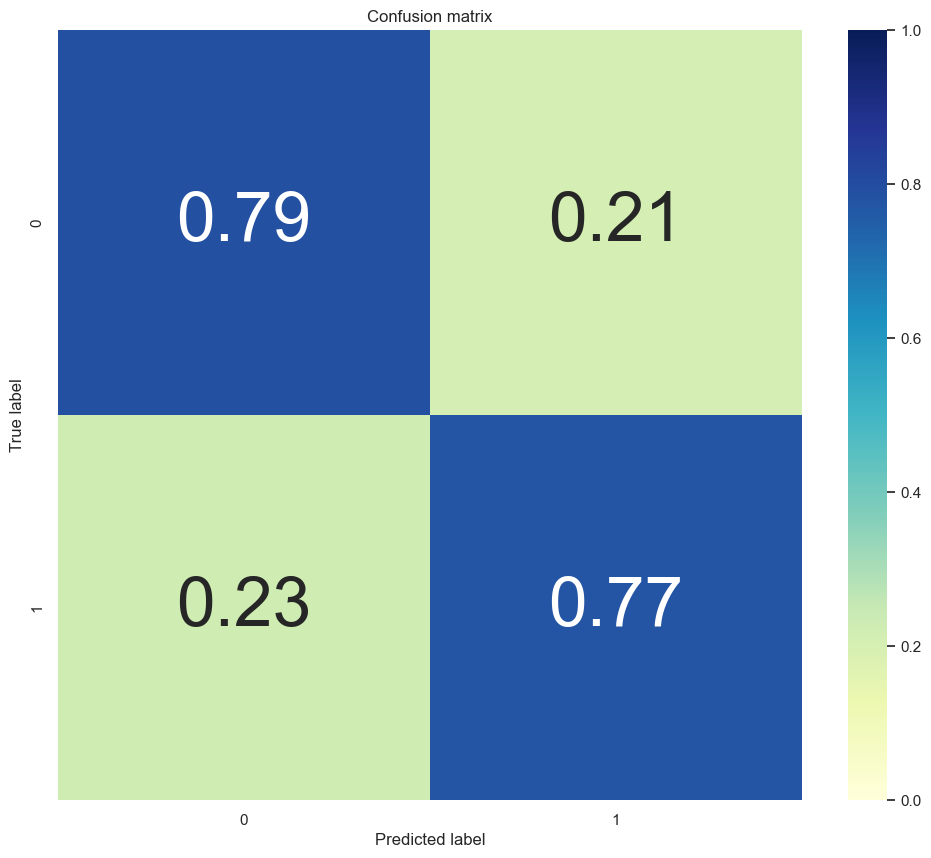

The CA of C parameter 20.6913808111479 is 0.77:
The Logg Loss of C parameter 20.6913808111479 is 0.4930782666894029:



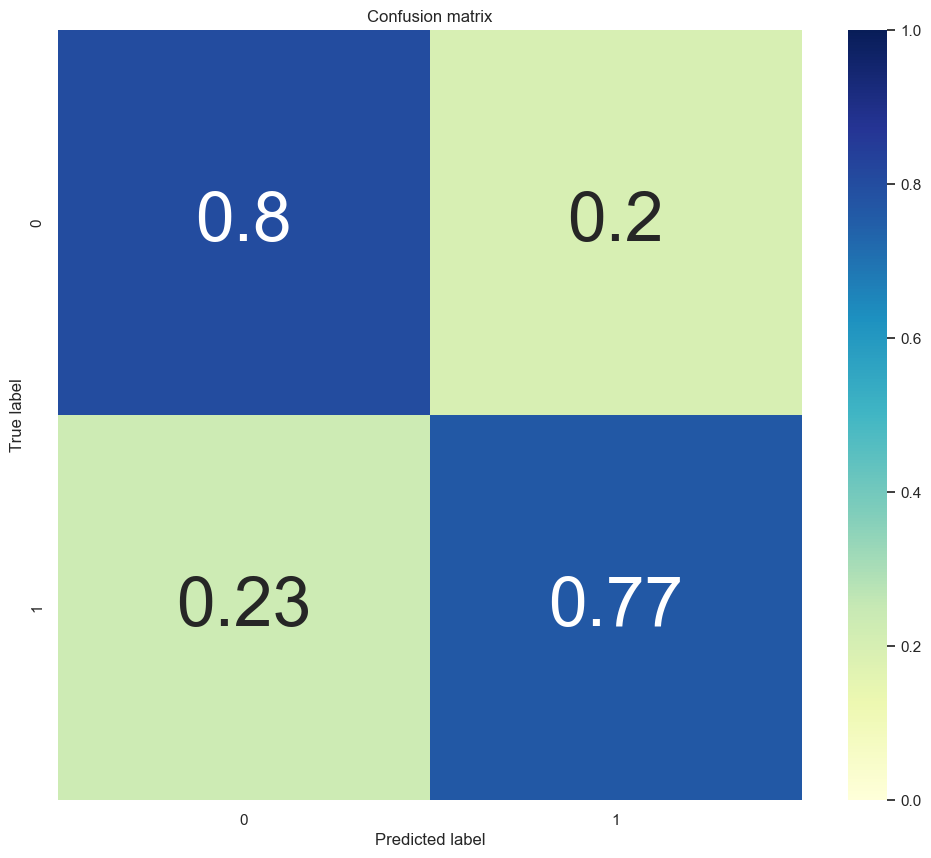

The CA of C parameter 69.51927961775606 is 0.77:
The Logg Loss of C parameter 69.51927961775606 is 0.49258616545643:



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


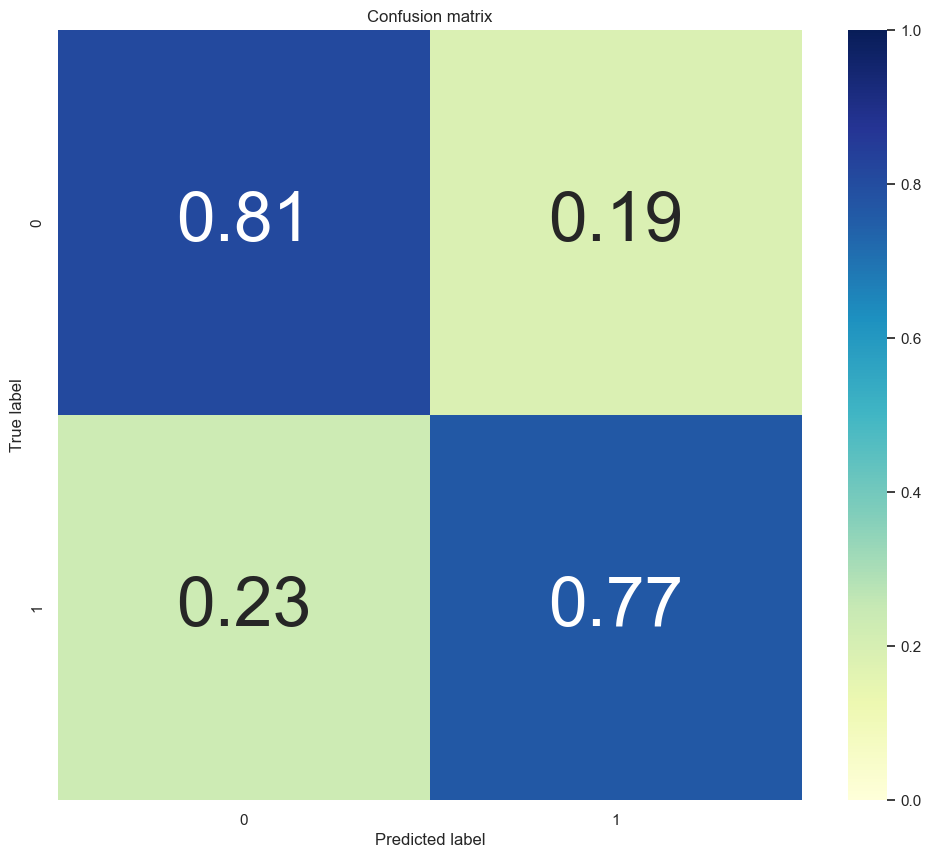

The CA of C parameter 233.57214690901213 is 0.755:
The Logg Loss of C parameter 233.57214690901213 is 0.4941455834363394:



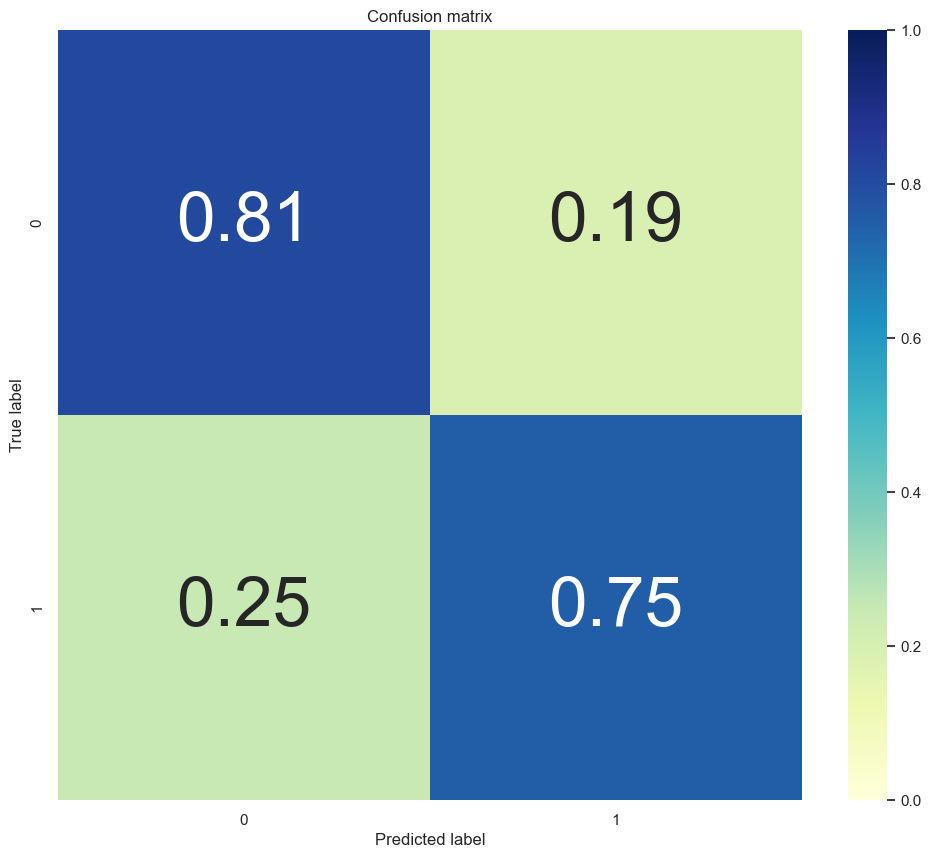

The CA of C parameter 784.7599703514607 is 0.775:
The Logg Loss of C parameter 784.7599703514607 is 0.487424738387688:



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


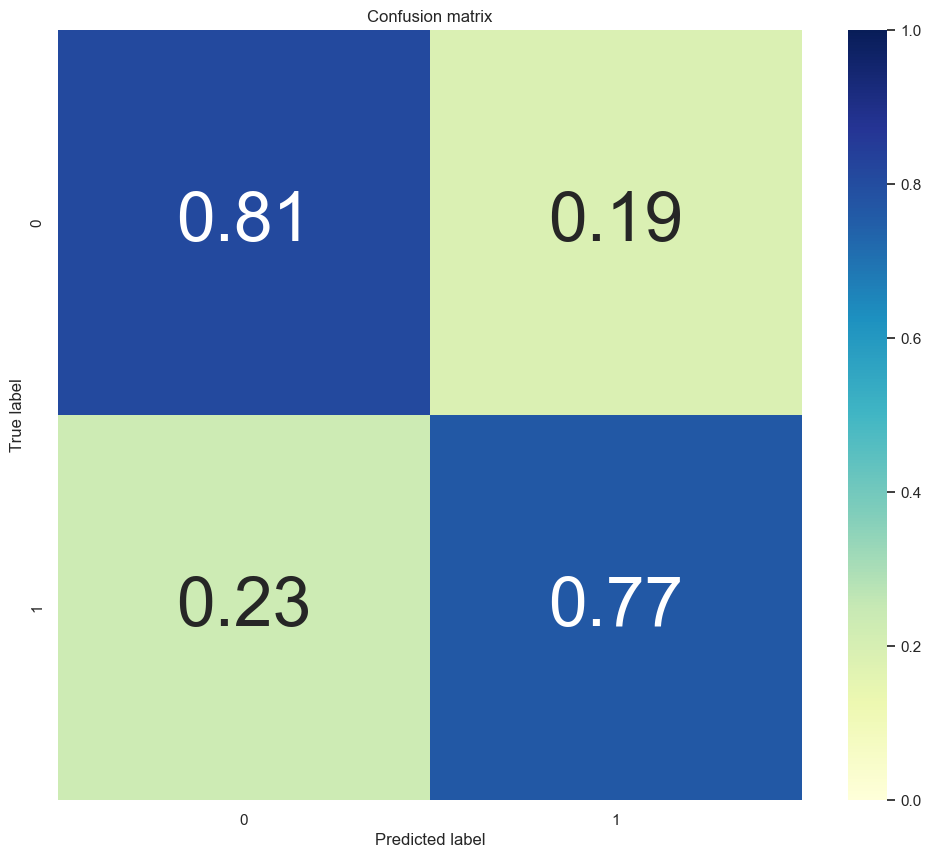

The CA of C parameter 2636.6508987303555 is 0.77:
The Logg Loss of C parameter 2636.6508987303555 is 0.49319267985208953:



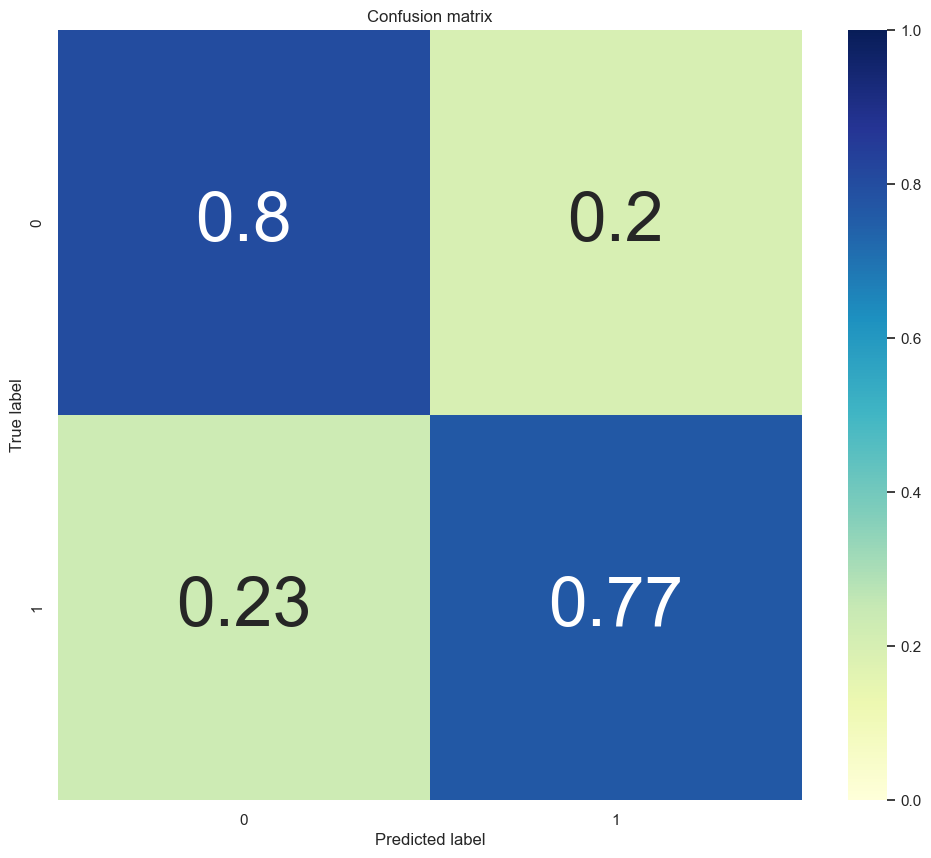

The CA of C parameter 8858.667904100832 is 0.77:
The Logg Loss of C parameter 8858.667904100832 is 0.4932270833010577:



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


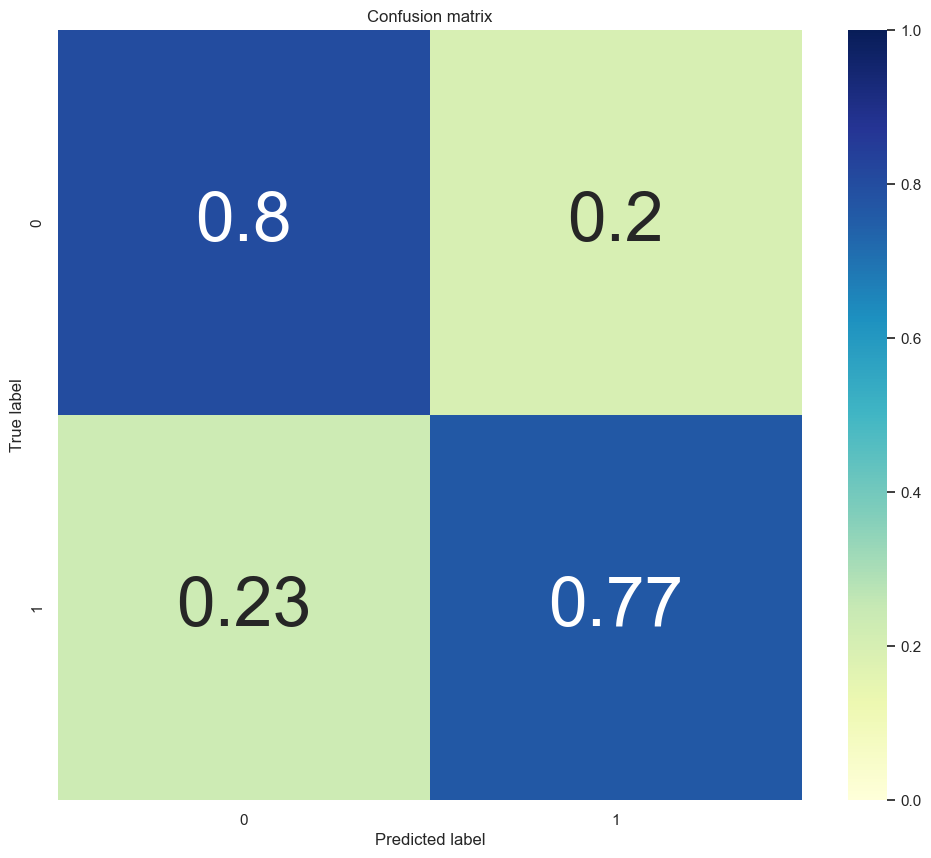

The CA of C parameter 29763.51441631313 is 0.77:
The Logg Loss of C parameter 29763.51441631313 is 0.4932016304586469:



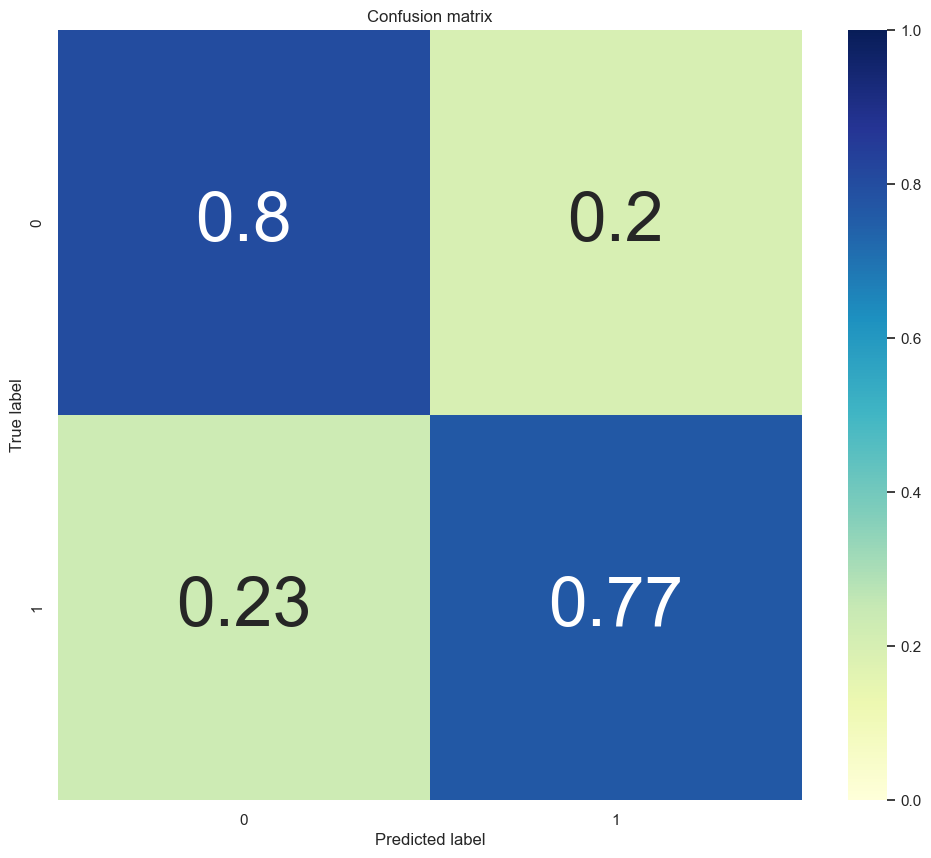

The CA of C parameter 100000.0 is 0.76:
The Logg Loss of C parameter 100000.0 is 0.4916040705319171:



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


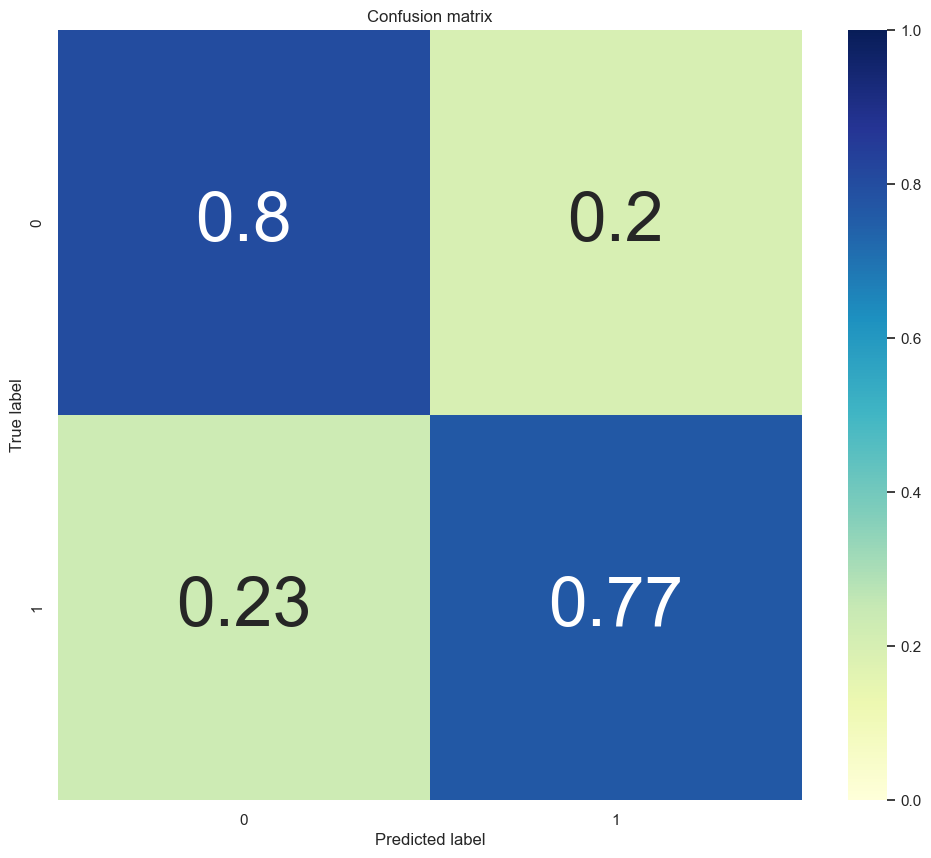

In [226]:
# Maybe we have a different metric we want to track

# Looping over the parameters

C_List = np.geomspace(1e-5, 1e5, num=20)
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'lbfgs', C=c)
    log_reg2.fit(X_train, y_train)
    score = log_reg2.score(X_test, y_test)
    CA.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg2.predict_proba(X_test)
    log_loss2 = log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")
    
    y_pred = log_reg2.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')
    plt.show()

# Dummy Classifier

In [227]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
score_dummy = dummy_clf.score(X_test, y_test)

pred_proba_t_dummy = dummy_clf.predict_proba(X_test)
log_loss2_dummy = log_loss(y_test, pred_proba_t_dummy)

print("Testing Acc:", score_dummy)
print("Log Loss:", log_loss2_dummy)


Testing Acc: 0.53
Log Loss: 16.233224905608022


In [228]:
# Final Model 

log_reg3 = LogisticRegression(random_state=10, solver = 'lbfgs', C=784.759970)
log_reg3.fit(X_train, y_train)
score = log_reg3.score(X_valid, y_valid)

pred_proba_t = log_reg3.predict_proba(X_valid)
log_loss2 = log_loss(y_valid, pred_proba_t)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)

Testing Acc: 0.7625
Log Loss: 0.4332660418412863


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
